<body><div class="alert alert-warning" style="text-align:center"><br>
<h1>made by <strong>Hanan Mohammad Alnakhal</strong></h1><br>
 student-id<strong> 220220202</strong>
 <br>
</div>

# ***importing libraries***

In [ ]:
import pandas as pd
import numpy as np
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import time
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA

# regression models that would be used 
from sklearn.linear_model import LinearRegression,HuberRegressor,ElasticNet,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor,ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,HistGradientBoostingRegressor,AdaBoostRegressor,ExtraTreesRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor

from sklearn import metrics 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from datetime import datetime 

import warnings # to ignore all warnings
warnings.filterwarnings("ignore")


# ***scrapping***
<div style="color:#ff1a40;background-color:Black;width:fit-content;"><strong>----- ONLY RUN THIS PART IF YOU WANT TO GET MORE DATA -----</strong></div>

## ***Getting the cookies*** 
- this step was done once to get the cookies using the cookies each time would help us come over the captcha in each session

In [ ]:
# driver = webdriver.Chrome()
# driver.get("https://uae.dubizzle.com/ar/motors/used-cars/?")

# input("Solve CAPTCHA and press ENTER here to save cookies...")

# with open("cookies.pkl", "wb") as file:
#     pickle.dump(driver.get_cookies(), file)

# print("✅ Cookies saved.")
# driver.quit()

## ***Making a driver for selenium***
- this function returns a driver to the desired website and then add cookies from the `cookies.pkl`_we got

In [ ]:
def Make_A_Driver(url):
    options = Options()
    options.add_argument("--start-maximized")
    driver = webdriver.Chrome(options=options)
    driver.get(url)
    with open("cookies.pkl", "rb") as file:
        cookies = pickle.load(file)

    for cookie in cookies:
        if "expiry" in cookie:
            del cookie["expiry"]  # Optional: avoid timestamp errors
        driver.add_cookie(cookie)
    # Reload page with cookies set
    driver.refresh()
    time.sleep(5)
    return driver

## ***fetch data***
- this function opens the website page and waits for it to load

In [9]:
def fetch_data(driver,url):
    driver.get(url)
    time.sleep(3)  # Adjust for page load time
    return driver.page_source

## ***Scrape Data***
- this gets the info from the html soup 

In [ ]:
def ScrapData(soup):
    PageData,result=[],{}
    allCarsDetails=soup.find_all("a", class_="mui-style-v8pseq")
    print(f"Total Cars Found: {len(allCarsDetails)}")
    for car_Card in range(len(allCarsDetails)):
        CarDescription=allCarsDetails[car_Card].find("div", class_="mui-style-1ez8sac") if allCarsDetails[car_Card].find("div", class_="mui-style-1ez8sac") else None
        price=CarDescription.find("div",{"data-testid": "listing-price"}).get_text(strip=True) if CarDescription.find("div", {"data-testid": "listing-price"}) else None # type: ignore
        Description=CarDescription.find("h2",{"data-testid": "subheading-text"}).get_text(strip=True) if CarDescription.find("h2", {"data-testid": "subheading-text"}) else None
        brand=CarDescription.find("h3",{"data-testid": "heading-text-1"}).get_text(strip=True)  if CarDescription.find("h3", {"data-testid": "heading-text-1"}) else None
        model=CarDescription.find("h3",{"data-testid": "heading-text-2"}).get_text(strip=True) if CarDescription.find("h3", {"data-testid": "heading-text-2"}) else None
        Ctype=CarDescription.find("h3",{"data-testid": "heading-text-3"}).get_text(strip=True) if CarDescription.find("h3", {"data-testid": "heading-text-3"}) else  None
        year=CarDescription.find("h3",{"data-testid": "listing-year"}).get_text(strip=True) if CarDescription.find("h3", {"data-testid": "listing-year"}) else None
        KM=CarDescription.find("h3",{"data-testid": "listing-kilometers"}).get_text(strip=True).replace("كم", "").strip() if CarDescription.find("h3", {"data-testid": "listing-kilometers"}) else None
        location=CarDescription.find("h4",class_="MuiTypography-root MuiTypography-body1 mui-style-t0mppt").get_text(strip=True) if CarDescription.find("h4",class_="MuiTypography-root MuiTypography-body1 mui-style-t0mppt") else None
        CarStandard=CarDescription.find("h3",{"data-testid": "listing-regional specs"}).get_text(strip=True) if CarDescription.find("h3",{"data-testid": "listing-regional specs"}) else None
        Steering_Side=CarDescription.find("h3",{"data-testid": "listing-steering side"}).get_text(strip=True) if CarDescription.find("h3",{"data-testid": "listing-steering side"}) else None
        if Steering_Side:
            Steering_Side="LEFT" if "اليسرى" in Steering_Side else "RIGHT"
        
        result={
            "Description": Description,
            "Location": location,
            "Brand": brand,
            "Model": model,
            "Car Type": Ctype,
            "Year": year,
            "KM": KM,
            "Car Standard": CarStandard,
            "Steering Side": Steering_Side,
            "Price": price,
        }
        PageData.append(result)
        # print(f"Car {car_Card + 1} details fetched successfully.")
    return PageData


## ***Getting the data from the search pages***
<div style="color:orange;background-color:#131313;width:fit-content;padding:15px"><strong>This part has been run many times inconsistently to get ⩬ 3000 record</strong></div>
<div style="color:skyblue;background-color:#131313;width:fit-content;padding:5px"><strong>The outpt each time was a csv file</strong></div>
<div style="color:skyblue;background-color:#131313;width:fit-content;padding:5px">each one has a different name with different data from different search page</div>

In [11]:
#creating a driver to the website with the cookies
DRIVER=Make_A_Driver("https://uae.dubizzle.com/ar/motors/used-cars/?")

In [ ]:
Data=[]#here each recored would be recorded as a dictionary
for i in range(61, 300): # _you could change the second number to get more pages up to 400
    print(f"Fetching data from page {i}...")
    website = fetch_data(DRIVER, f"https://uae.dubizzle.com/ar/motors/used-cars/?page={i}")#this open search page 
    soup = BeautifulSoup(website, "html.parser")
    data = ScrapData(soup)
    Data.extend(data)
    print(f"Page {i} data fetched successfully.")
    time.sleep(2)  

Fetching data from page 61...
Total Cars Found: 26
Page 61 data fetched successfully.
Fetching data from page 62...
Total Cars Found: 26
Page 62 data fetched successfully.
Fetching data from page 63...
Total Cars Found: 26
Page 63 data fetched successfully.
Fetching data from page 64...
Total Cars Found: 26
Page 64 data fetched successfully.
Fetching data from page 65...
Total Cars Found: 26
Page 65 data fetched successfully.
Fetching data from page 66...
Total Cars Found: 26
Page 66 data fetched successfully.
Fetching data from page 67...
Total Cars Found: 26
Page 67 data fetched successfully.
Fetching data from page 68...
Total Cars Found: 26
Page 68 data fetched successfully.
Fetching data from page 69...
Total Cars Found: 26
Page 69 data fetched successfully.
Fetching data from page 70...
Total Cars Found: 26
Page 70 data fetched successfully.
Fetching data from page 71...
Total Cars Found: 26
Page 71 data fetched successfully.
Fetching data from page 72...
Total Cars Found: 26
Pag

KeyboardInterrupt: 

In [18]:
# turnin the data into a DataFrame then saving it locally as a CSV
df = pd.DataFrame(Data)
df.to_csv("Page_61To100.csv",index=False, encoding="utf-8-sig")
print("Data scraping completed.✨")
print(f"saved to Dubizzle_Used_Cars_V2_MoreData.csv")

Data scraping completed.✨
saved to Dubizzle_Used_Cars_V2_MoreData.csv


# ***Data Cleaning & preparation***
<div style="color:lightgreen;background-color:#131313;width:fit-content;padding:5px;font-size:20px"><strong>transforming the row extracted Data </strong></div>

- <div style="color:skyblue;background-color:#131313;width:fit-content;padding:5px"> 3 CSV files into one Dataset that has proper index</div>
- <div style="color:skyblue;background-color:#131313;width:fit-content;padding:5px"> handling missing data,duplicates</div>
- <div style="color:skyblue;background-color:#131313;width:fit-content;padding:5px"> Data types transforming </div>

    - (e.g.: price was text type even though it containd numeric)
- <div style="color:skyblue;background-color:#131313;width:fit-content;padding:5px"> basic feature extraction :</div>

    - manual    ->  if the car has a manual gear 
    - emara     ->  transforming the location into just the emara with 8 possible values

- <div style="color:skyblue;background-color:#131313;width:fit-content;padding:5px"> translating the language from ARabic to English</div>

## ***reading the row_output files***
- ## ***combining all csv files***

In [2]:
Data1=pd.read_csv("Dubizzle_Used_Cars.csv",index_col='Unnamed: 0',na_values='nan')
Data2=pd.read_csv("Dubizzle_Used_Cars_V2_page1_60.csv",na_values='nan')
Data3=pd.read_csv("Page_61To100.csv",na_values='nan')
MyData=pd.concat([Data1,Data2,Data3])
MyData.shape

(3614, 11)

In [3]:
MyData.head()

,Description,Location,Brand,Model,Car Type,Year,KM,Manual,Car Standard,Steering Side,Price
0,2025 BRAND NEW SOUEAST SO6 COMFORT | 6 YEARS W...,"القوز, دبي",ساوايست,S06,Other,2025,15,False,مواصفات خليجية,LEFT,"69,000"
1,2025 BYD YUAN UP 401KM SMART DRIVER BEYOND EDI...,"رأس الخور, دبي",بي واي دي,Yuan up,Other,2025,0,False,مواصفات صينية,LEFT,"62,000"
2,BIG DEAL - FSH - ACCIDENT FREE - AUDI Q3 TFSI ...,"البرشاء, دبي",أودي,Q3,35 TFSI Quattro,2015,"160,000",False,مواصفات خليجية,LEFT,"34,000"
3,NISSAN SUNNY 1.6L - 2021 MODEL - GCC Specifica...,"منطقة سیف (المنطقة الحرة بمطار الشارقة‬), الشارقة",نيسان,سَني,Base,2021,"119,000",False,مواصفات خليجية,LEFT,"22,000"
4,BMW 740i,"منطقة سیف (المنطقة الحرة بمطار الشارقة‬), الشارقة",بي ام دبليو,7 - السلسلة,740Li xDrive,2018,"183,000",False,مواصفات خليجية,LEFT,"85,000"


In [4]:
MyData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3614 entries, 0 to 1039
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Description    3614 non-null   object
 1   Location       3614 non-null   object
 2   Brand          3614 non-null   object
 3   Model          3614 non-null   object
 4   Car Type       3612 non-null   object
 5   Year           3614 non-null   int64 
 6   KM             3614 non-null   object
 7   Manual         3614 non-null   object
 8   Car Standard   3613 non-null   object
 9   Steering Side  3613 non-null   object
 10  Price          3614 non-null   object
dtypes: int64(1), object(10)
memory usage: 338.8+ KB


### ***updating index***
- since I used 3 csv files then each one has its own index 
- for example we had 3 recordes with the index 0 !
- in the following code I updated the index to make it from 0 to number of records


In [5]:
MyData.index=[i for i in range(0,MyData.shape[0])]

## ***dealing with missing values***
as we can see :
|colnum|colname|non-null|Missing|
|--|-------|-----|---|
|8  | Car Standard   |3613 non-null |1| 
|9   |Steering Side | 3613 non-null|1|
|4   |Car Type       |3612 non-null|2|
|Total records|*|3614 records|4 values|
- since they are nominal I Imputed them with the most Common value _mode_
- only the car type I assumed that it is in the category "Other" 

In [6]:
MyData[MyData["Car Standard"].isnull()]

,Description,Location,Brand,Model,Car Type,Year,KM,Manual,Car Standard,Steering Side,Price
1140,2013 GMC Youkon Denali Orignal Paint 1st Owner...,"العوير, دبي",جي ام سي,يوكون,Denali,2013,"222,000",0,NaN,NaN,"39,999"


In [225]:
print(MyData[MyData.Brand=="جي ام سي"]["Car Standard"].value_counts())
print(MyData[MyData.Brand=="جي ام سي"]["Steering Side"].value_counts())

مواصفات خليجية     19
مواصفات أوروبية     1
Name: Car Standard, dtype: int64
LEFT    20
Name: Steering Side, dtype: int64


In [226]:
MyData["Car Standard"].fillna('مواصفات خليجية',inplace=True)
MyData["Steering Side"].fillna("LEFT",inplace=True)

In [227]:
MyData[MyData["Car Type"].isnull()]

,Description,Location,Brand,Model,Car Type,Year,KM,Manual,Car Standard,Steering Side,Price
151,2023 F8 SPIDER | FULL INTERIOR CARBON | SUSPEN...,"القوز, دبي",فيراري,F8 سبايدر,NaN,2023,500,False,مواصفات أوروبية,LEFT,"1,495,000"
866,FERRARI | F8 SPIDER | 2022MY | CARBON FIBER | ...,"القوز, دبي",فيراري,F8 سبايدر,NaN,2022,"3,000",False,مواصفات أخرى,LEFT,"1,250,000"


In [228]:
MyData["Car Type"].value_counts()

Other              389
Standard           155
S-line             114
SE                  78
RS                  70
                  ... 
C200 Avantgarde      1
Autograph            1
Exploration          1
Super                1
WRX                  1
Name: Car Type, Length: 695, dtype: int64

In [229]:
MyData["Car Type"].fillna("Other",inplace=True)

In [230]:
MyData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3614 entries, 0 to 3613
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Description    3614 non-null   object
 1   Location       3614 non-null   object
 2   Brand          3614 non-null   object
 3   Model          3614 non-null   object
 4   Car Type       3614 non-null   object
 5   Year           3614 non-null   int64 
 6   KM             3614 non-null   object
 7   Manual         3614 non-null   object
 8   Car Standard   3614 non-null   object
 9   Steering Side  3614 non-null   object
 10  Price          3614 non-null   object
dtypes: int64(1), object(10)
memory usage: 338.8+ KB


## ***adding the `Manual` feature***
- this feature tells if the care is manual or automatic gear 

In [231]:
MyData["Manual"]=MyData["Description"].apply(lambda x:1 if "manual" in x.lower() else 0)

In [232]:
MyData["Manual"].value_counts()

0    3592
1      22
Name: Manual, dtype: int64

## ***removing duplicates***
- this step was done since the data wasn't scraped in one set and it may contain duplicates

In [233]:
print("duplicates count:",np.sum(MyData.duplicated()))

duplicates count: 451


In [234]:
MyData=MyData.drop_duplicates()
print("duplicates count:",np.sum(MyData.duplicated()))

duplicates count: 0


In [235]:
MyData.head()

,Description,Location,Brand,Model,Car Type,Year,KM,Manual,Car Standard,Steering Side,Price
0,2025 BRAND NEW SOUEAST SO6 COMFORT | 6 YEARS W...,"القوز, دبي",ساوايست,S06,Other,2025,15,0,مواصفات خليجية,LEFT,"69,000"
1,2025 BYD YUAN UP 401KM SMART DRIVER BEYOND EDI...,"رأس الخور, دبي",بي واي دي,Yuan up,Other,2025,0,0,مواصفات صينية,LEFT,"62,000"
2,BIG DEAL - FSH - ACCIDENT FREE - AUDI Q3 TFSI ...,"البرشاء, دبي",أودي,Q3,35 TFSI Quattro,2015,"160,000",0,مواصفات خليجية,LEFT,"34,000"
3,NISSAN SUNNY 1.6L - 2021 MODEL - GCC Specifica...,"منطقة سیف (المنطقة الحرة بمطار الشارقة‬), الشارقة",نيسان,سَني,Base,2021,"119,000",0,مواصفات خليجية,LEFT,"22,000"
4,BMW 740i,"منطقة سیف (المنطقة الحرة بمطار الشارقة‬), الشارقة",بي ام دبليو,7 - السلسلة,740Li xDrive,2018,"183,000",0,مواصفات خليجية,LEFT,"85,000"


In [236]:
MyData.shape

(3163, 11)

## ***turning string numbers into numbers***

In [60]:
MyData["Price"]=pd.to_numeric(MyData["Price"].apply(lambda x: x.replace(",","")))
MyData["KM"]=pd.to_numeric(MyData["KM"].apply(lambda x: x.replace(",","")))

In [238]:
MyData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3163 entries, 0 to 3613
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Description    3163 non-null   object
 1   Location       3163 non-null   object
 2   Brand          3163 non-null   object
 3   Model          3163 non-null   object
 4   Car Type       3163 non-null   object
 5   Year           3163 non-null   int64 
 6   KM             3163 non-null   int64 
 7   Manual         3163 non-null   int64 
 8   Car Standard   3163 non-null   object
 9   Steering Side  3163 non-null   object
 10  Price          3163 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 296.5+ KB


## ***Limiting LOcation by "the emara"***

دبي           0.841290
الشارقة       0.091053
أبو ظبي       0.051217
عجمان         0.013279
العين         0.001265
رأس الخيمة    0.001265
أم القيوين    0.000316
الفجيرة       0.000316
Name: Location, dtype: float64


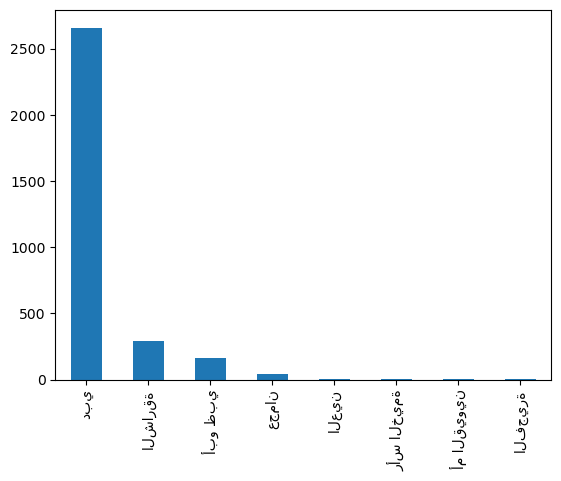

In [239]:
LoC=MyData.Location.apply(lambda x: x.split(",")[1].strip() if len(x.split(","))==2 else x.split(",")[0].strip())
LoC.value_counts().plot(kind="bar")
print(LoC.value_counts(normalize=True))

- we have 7 emarits I know ..But "العين" does exist
- I'm thinking about keeping the 3 most frequent locations and leave the others as "other" by that we would have 4 categories

In [240]:
MyData['Emara']=LoC
MyData

,Description,Location,Brand,Model,Car Type,Year,KM,Manual,Car Standard,Steering Side,Price,Emara
0,2025 BRAND NEW SOUEAST SO6 COMFORT | 6 YEARS W...,"القوز, دبي",ساوايست,S06,Other,2025,15,0,مواصفات خليجية,LEFT,69000,دبي
1,2025 BYD YUAN UP 401KM SMART DRIVER BEYOND EDI...,"رأس الخور, دبي",بي واي دي,Yuan up,Other,2025,0,0,مواصفات صينية,LEFT,62000,دبي
2,BIG DEAL - FSH - ACCIDENT FREE - AUDI Q3 TFSI ...,"البرشاء, دبي",أودي,Q3,35 TFSI Quattro,2015,160000,0,مواصفات خليجية,LEFT,34000,دبي
3,NISSAN SUNNY 1.6L - 2021 MODEL - GCC Specifica...,"منطقة سیف (المنطقة الحرة بمطار الشارقة‬), الشارقة",نيسان,سَني,Base,2021,119000,0,مواصفات خليجية,LEFT,22000,الشارقة
4,BMW 740i,"منطقة سیف (المنطقة الحرة بمطار الشارقة‬), الشارقة",بي ام دبليو,7 - السلسلة,740Li xDrive,2018,183000,0,مواصفات خليجية,LEFT,85000,الشارقة
...,...,...,...,...,...,...,...,...,...,...,...,...
3609,RENAULT DUSTER GCC AGENCY MAINTAIN CAR FOR SALE.,"القصيص, دبي",رينو,دستر,LE,2014,172000,0,مواصفات خليجية,LEFT,11500,دبي
3610,"2023 Mazda CX-30 – 14,750 km – GCC Specs –","مرسى خور دبي, دبي",مازدا,CX-30,Urban,2023,14750,0,مواصفات خليجية,LEFT,77500,دبي
3611,DUBAI,"وسط مدينة دبي, دبي",سوبارو,WRX,WRX,2022,43000,0,مواصفات أمريكية,LEFT,85000,دبي
3612,2012 Audi A5 S-line-TFSI-Quattro(AWD)-GCC- No ...,"البرشاء, دبي",أودي,A5,40 TFSI S-Line,2012,195000,0,مواصفات خليجية,LEFT,25000,دبي


## ***Language translation***
## ***from `Arabic` to `English`***

### ***translating the brand***

In [241]:
MyData.Brand.unique()

array(['ساوايست', 'بي واي دي', 'أودي', 'نيسان', 'بي ام دبليو', 'ميني',
       'لاند روفر', 'جاك', 'لكزس', 'إنفينيتي', 'مازيراتي', 'تويوتا',
       'مرسيدس بنز', 'رولز رويس', 'كاديلاك', 'فورد', 'ميتسوبيشي', 'رينو',
       'مازدا', 'هيونداي', 'فولكسفاغن', 'جاكوار', 'لامبورغيني', 'دودج',
       'كيا', 'Tova', 'الفا روميو', 'إم جي', 'جي أي سي', 'بورشه', 'فيات',
       'أبارث', 'سوزوكي', 'فينغون', 'هوندا', 'مرسيدس-مايباخ', 'جيلي',
       'شيفروليه', 'جي ام سي', 'جيب', 'جيتور', 'فيراري', 'بنتلي', 'تسلا',
       'بيجو', 'تشانجان', 'فولفو', 'VGV', 'لينكولن', 'رام', 'هافال',
       'أستون مارتن', 'هونشي', 'Rox', 'TANK', 'سيتروين', 'ماكلارين',
       'زيكر', 'هامر', 'أوبل', 'فوتون', 'سكودا', 'بريليانس', 'سمارت',
       'AITO', 'اكسيد', 'Polestar', 'ايسوزو', 'سوبارو', 'جينيسيس',
       'Rabdan', 'كرايسلر', 'Bentley Onyx'], dtype=object)

In [242]:
CarsBrands={
    'ساوايست':"SOUEAST", 
    'بي واي دي':"BYD",
    'أودي':"Audi",
    'نيسان':"Nissan",
    'بي ام دبليو' :"BMW",
    'ميني':"Mini",
    'لاند روفر':"LAND ROVER",
    'جاك':"JAC",
    'لكزس':"Lexus", 
    'إنفينيتي':"Infiniti", 
    'مازيراتي':"MASERATI", 
    'تويوتا':"TOYOTA",
    'مرسيدس بنز':"MERCEDES BENZ",
    'رولز رويس':"Rolls-Royce", 
    'كاديلاك':"CADILLAC", 
    'فورد':"Ford", 
    'ميتسوبيشي':"Mitsubishi", 
    'رينو':"RENAULT",
    'مازدا':"Mazda", 
    'هيونداي':"Hyundai", 
    'فولكسفاغن':"Volkswagen", 
    'جاكوار':"Jaguar", 
    'لامبورغيني':"Lamborghini", 
    'دودج':"Dodge",
    'كيا':"Kia", 
    'Tova':"Tova", 
    'الفا روميو':"Alfa Romeo", 
    'إم جي':"MG", 
    'جي أي سي':"GAC", 
    'بورشه':"PORSCHE", 
    'فيات':"FIAT",
    'أبارث':"Abarth", 
    'سوزوكي':"Suzuki", 
    'فينغون':"Fengon", 
    'هوندا':"HONDA", 
    'مرسيدس-مايباخ':"Mercedes-Maybach", 
    'جيلي':"GEELY",
    'شيفروليه':"CHEVROLET", 
    'جي ام سي':"GMC", 
    'جيب':"JEEP", 
    'جيتور':"Jetour", 
    'فيراري':"FERRARI", 
    'بنتلي':"Bentley", 
    'تسلا':"TESLA",
    'بيجو':"PEUGEOT", 
    'تشانجان':"CHANGAN", 
    'فولفو':"VOLVO", 
    'VGV':"VGV", 
    'لينكولن':"Lincoln", 
    'رام':"RAM", 
    'هافال':"HAVAL",
    'أستون مارتن':"Aston Martin", 
    'هونشي':"Hongqi", 
    'Rox':"Rox", 
    'TANK':"TANK", 
    'سيتروين':"CITROËN", 
    'ماكلارين':"McLaren",
    'زيكر':"ZEEKR", 
    'هامر':"HUMMER", 
    'أوبل':"OPEL",
    'فوتون':"Foton",
    'سكودا':"Skoda",
    "بريليانس":"Brilliance",
    "سمارت":"Smart",
    "AITO":"AITO",
    "اكسيد":"EXEED",
    "Polestar":"Polestar",
    "ايسوزو":"ISUZU",
    "سوبارو":"SUBARU", 
    "جينيسيس":"jenesis",
    "Rabdan":"Rabdan",
    "كرايسلر":"Chrysler",
    "Bentley Onyx":"Bentley Onyx"
}
len(CarsBrands.keys())


73

In [243]:
MyData.Brand=[CarsBrands[x]for x in MyData.Brand]

In [244]:
MyData.head()

,Description,Location,Brand,Model,Car Type,Year,KM,Manual,Car Standard,Steering Side,Price,Emara
0,2025 BRAND NEW SOUEAST SO6 COMFORT | 6 YEARS W...,"القوز, دبي",SOUEAST,S06,Other,2025,15,0,مواصفات خليجية,LEFT,69000,دبي
1,2025 BYD YUAN UP 401KM SMART DRIVER BEYOND EDI...,"رأس الخور, دبي",BYD,Yuan up,Other,2025,0,0,مواصفات صينية,LEFT,62000,دبي
2,BIG DEAL - FSH - ACCIDENT FREE - AUDI Q3 TFSI ...,"البرشاء, دبي",Audi,Q3,35 TFSI Quattro,2015,160000,0,مواصفات خليجية,LEFT,34000,دبي
3,NISSAN SUNNY 1.6L - 2021 MODEL - GCC Specifica...,"منطقة سیف (المنطقة الحرة بمطار الشارقة‬), الشارقة",Nissan,سَني,Base,2021,119000,0,مواصفات خليجية,LEFT,22000,الشارقة
4,BMW 740i,"منطقة سیف (المنطقة الحرة بمطار الشارقة‬), الشارقة",BMW,7 - السلسلة,740Li xDrive,2018,183000,0,مواصفات خليجية,LEFT,85000,الشارقة


### ***translating car standards***

In [245]:
MyData['Car Standard'].value_counts()

مواصفات خليجية     2447
مواصفات أمريكية     265
مواصفات أخرى        117
مواصفات أوروبية     104
مواصفات يابانية      95
مواصفات صينية        58
مواصفات كندية        45
مواصفات كورية        32
Name: Car Standard, dtype: int64

In [246]:
Standards='''مواصفات خليجية     
مواصفات أمريكية     
مواصفات أخرى        
مواصفات أوروبية     
مواصفات يابانية     
مواصفات صينية       
مواصفات كورية       
مواصفات كندية'''.split("\n")
Standards=[x.strip() for x in Standards]

StandardsEn="""Gulf
American
Other
European
Japanese
Chinese
Korean
Canadian""".split("\n")
StandardsEn=[x.strip() for x in StandardsEn]
StandardDic={Standards[i]:StandardsEn[i] for i in range(len(Standards))}
StandardDic

{'مواصفات خليجية': 'Gulf',
 'مواصفات أمريكية': 'American',
 'مواصفات أخرى': 'Other',
 'مواصفات أوروبية': 'European',
 'مواصفات يابانية': 'Japanese',
 'مواصفات صينية': 'Chinese',
 'مواصفات كورية': 'Korean',
 'مواصفات كندية': 'Canadian'}

In [247]:
MyData["Car Standard"]=[StandardDic[i] for i in MyData["Car Standard"]]

In [248]:
MyData["Car Standard"].value_counts()

Gulf        2447
American     265
Other        117
European     104
Japanese      95
Chinese       58
Canadian      45
Korean        32
Name: Car Standard, dtype: int64

### ***translating 'Emara'***

In [249]:
AR='''دبي      
الشارقة
أبو ظبي
عجمان  
العين  
رأس الخيمة  
أم القيوين 
الفجيرة
'''.split("\n")
AR=[x.strip() for x in AR]
en=["dubai","alshareqa","abu dhabi","ajman","alein","ras Alkhaima","Om alqewain","alfojera"]
ArEn={x:i for x,i in zip(AR,en)}
ArEn

{'دبي': 'dubai',
 'الشارقة': 'alshareqa',
 'أبو ظبي': 'abu dhabi',
 'عجمان': 'ajman',
 'العين': 'alein',
 'رأس الخيمة': 'ras Alkhaima',
 'أم القيوين': 'Om alqewain',
 'الفجيرة': 'alfojera'}

In [250]:
MyData.Emara=[ArEn[i] for i in MyData["Emara"]]

In [251]:
MyData.head()

,Description,Location,Brand,Model,Car Type,Year,KM,Manual,Car Standard,Steering Side,Price,Emara
0,2025 BRAND NEW SOUEAST SO6 COMFORT | 6 YEARS W...,"القوز, دبي",SOUEAST,S06,Other,2025,15,0,Gulf,LEFT,69000,dubai
1,2025 BYD YUAN UP 401KM SMART DRIVER BEYOND EDI...,"رأس الخور, دبي",BYD,Yuan up,Other,2025,0,0,Chinese,LEFT,62000,dubai
2,BIG DEAL - FSH - ACCIDENT FREE - AUDI Q3 TFSI ...,"البرشاء, دبي",Audi,Q3,35 TFSI Quattro,2015,160000,0,Gulf,LEFT,34000,dubai
3,NISSAN SUNNY 1.6L - 2021 MODEL - GCC Specifica...,"منطقة سیف (المنطقة الحرة بمطار الشارقة‬), الشارقة",Nissan,سَني,Base,2021,119000,0,Gulf,LEFT,22000,alshareqa
4,BMW 740i,"منطقة سیف (المنطقة الحرة بمطار الشارقة‬), الشارقة",BMW,7 - السلسلة,740Li xDrive,2018,183000,0,Gulf,LEFT,85000,alshareqa


## ***Saving the ready to use data***________________________________

In [ ]:
# MyData.groupby(by='Car Type')["Price"].mean().sort_values(ascending=False)[:30]
# len(MyData["Car Type"].unique())
#here I noticed that the car type and the Model are not really useful and the brand itself may play a bigger part n determining the price 

Car Type
Competizione                 2.954960e+06
LP 770-4 Superveloce Jota    1.799000e+06
Black Badge                  1.649346e+06
Extended Wheel Base          1.533333e+06
GT3 RS                       1.450000e+06
G 700                        1.349999e+06
Sterrato                     1.299000e+06
GTC S                        1.295000e+06
GTC Mulliner                 1.199000e+06
Assetto Fiorano              1.195000e+06
EVO Spyder                   1.150000e+06
Turbo S Cabriolet            1.135000e+06
S 680                        1.099900e+06
EVO Coupe                    9.990000e+05
GT3                          9.380000e+05
SV Autobiography             8.950000e+05
Spider                       8.470000e+05
Lp570-4 Superleggera         7.850000e+05
GT Speed                     7.724975e+05
GLE 63 AMG                   7.535000e+05
Turbo S                      7.434000e+05
G 63 AMG                     7.381293e+05
LP 580-2 Spyder              7.350000e+05
LP 610-4 Spyder          

In [253]:
MyInfo=MyData[['Emara','Brand','Year','KM','Manual','Car Standard','Steering Side','Price'	]].copy()
MyInfo.columns=["_".join(x.lower().strip().split()) for x in MyInfo.columns]
MyInfo.head()

,emara,brand,year,km,manual,car_standard,steering_side,price
0,dubai,SOUEAST,2025,15,0,Gulf,LEFT,69000
1,dubai,BYD,2025,0,0,Chinese,LEFT,62000
2,dubai,Audi,2015,160000,0,Gulf,LEFT,34000
3,alshareqa,Nissan,2021,119000,0,Gulf,LEFT,22000
4,alshareqa,BMW,2018,183000,0,Gulf,LEFT,85000


In [254]:
MyInfo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3163 entries, 0 to 3613
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emara          3163 non-null   object
 1   brand          3163 non-null   object
 2   year           3163 non-null   int64 
 3   km             3163 non-null   int64 
 4   manual         3163 non-null   int64 
 5   car_standard   3163 non-null   object
 6   steering_side  3163 non-null   object
 7   price          3163 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 222.4+ KB


In [255]:
MyInfo.to_csv("Dubizzle_UsedCars_V1_NOCarType_Model.csv",index=False, encoding="utf-8")

# ***EDA***
- <div style="color:lightgreen;background-color:#131313;width:fit-content;padding:5px;font-size:20px"><strong>understanding general relationships</strong></div>
- <div style="color:lightgreen;background-color:#131313;width:fit-content;padding:5px;font-size:20px"><strong>dealing with outliers</strong></div>
- <div style="color:lightgreen;background-color:#131313;width:fit-content;padding:5px;font-size:20px"><strong>encoding categories</strong></div>

In [ ]:
used_Cars=pd.read_csv("Dubizzle_UsedCars_V1.csv")#the output file from the prev step

In [34]:
used_Cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3163 entries, 0 to 3162
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emara          3163 non-null   object
 1   brand          3163 non-null   object
 2   model          3163 non-null   object
 3   car_type       3163 non-null   object
 4   year           3163 non-null   int64 
 5   km             3163 non-null   int64 
 6   manual         3163 non-null   int64 
 7   car_standard   3163 non-null   object
 8   steering_side  3163 non-null   object
 9   price          3163 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 247.2+ KB


In [35]:
# print("unique models in the data set:",len(used_Cars.groupby(["brand","car_type"])["price"].sum()))
# used_Cars.groupby("model")["price"].count().sort_values(ascending=True)[:20]
used_Cars.groupby(["car_type"])["price"].mean().sort_values(ascending=False)#.sort_values(ascending=False)[:20]

car_type
Competizione                 2.954960e+06
LP 770-4 Superveloce Jota    1.799000e+06
Black Badge                  1.617923e+06
Extended Wheel Base          1.533333e+06
GT3 RS                       1.450000e+06
                                 ...     
Quattro                      1.600000e+04
Unlimited                    1.500000e+04
Plus Black Edition           1.200000e+04
Pure                         1.100000e+04
VAN                          9.000000e+03
Name: price, Length: 695, dtype: float64

In [36]:
print("unique car_type in the data set:",len(used_Cars.car_type.unique()))
used_Cars.groupby("car_type")["price"].mean().sort_values(ascending=False)[:20]

unique car_type in the data set: 695


car_type
Competizione                 2.954960e+06
LP 770-4 Superveloce Jota    1.799000e+06
Black Badge                  1.617923e+06
Extended Wheel Base          1.533333e+06
GT3 RS                       1.450000e+06
G 700                        1.349999e+06
Sterrato                     1.299000e+06
GTC S                        1.295000e+06
GTC Mulliner                 1.199000e+06
Assetto Fiorano              1.195000e+06
EVO Spyder                   1.150000e+06
Turbo S Cabriolet            1.135000e+06
S 680                        1.099900e+06
EVO Coupe                    1.023000e+06
GT3                          9.380000e+05
SV Autobiography             8.950000e+05
Turbo S                      8.693333e+05
Spider                       8.470000e+05
Lp570-4 Superleggera         7.850000e+05
GT Speed                     7.724975e+05
Name: price, dtype: float64

## ***exploring numeric features***

In [37]:
used_Cars.describe()

,year,km,manual,price
count,3163.000000,3163.000000,3163.000000,3.163000e+03
mean,2019.975340,75559.925703,0.005375,2.163665e+05
std,4.141858,70862.828958,0.073126,5.701492e+05
min,1984.000000,0.000000,0.000000,7.000000e+03
25%,2017.000000,14000.000000,0.000000,4.800000e+04
50%,2021.000000,64504.000000,0.000000,9.490000e+04
75%,2023.000000,115379.000000,0.000000,1.990000e+05
max,2026.000000,820000.000000,1.000000,1.450000e+07


### ***Relationships:***

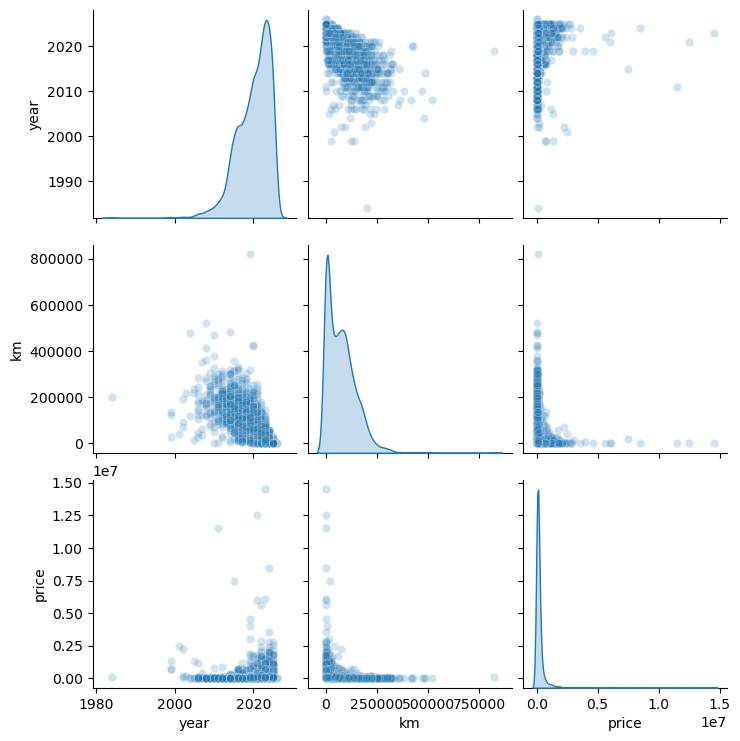

In [38]:
sns.pairplot(used_Cars[["year","km","price"]],diag_kind="kde",plot_kws={'alpha': 0.2});

> ### the more recent is the car, the more likely it is to have a higher price

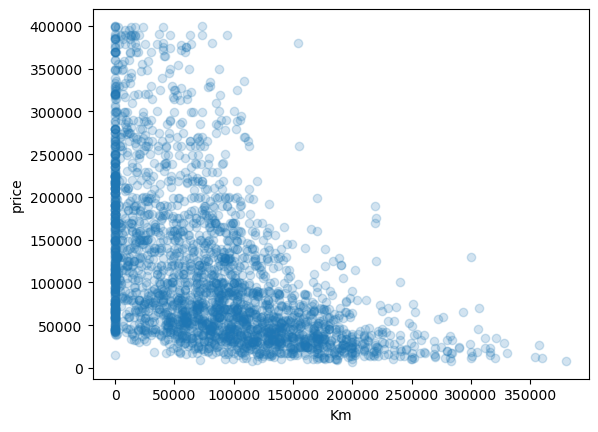

In [39]:
plt.scatter(used_Cars[used_Cars.price<400000][used_Cars.km<400000].km,used_Cars[used_Cars.price<400000][used_Cars.km<400000].price,alpha=0.2);
plt.xlabel("Km")
plt.ylabel("price");

> ### the more kilometers the less potential price 

## **Detecting *Outliers* in numeric values**

### **kilometers**

The deleted record:
          emara       brand        model    car_type  year      km  manual  \
226   alshareqa      TOYOTA  اف جي كروزر         VXR  2010  471000       0   
975       dubai      TOYOTA        برادو      VX MID  2008  520000       0   
987   alshareqa      TOYOTA        برادو    VX Basic  2004  480000       0   
1456      dubai      TOYOTA       أفالون  V6 Limited  2019  820000       0   
2569      dubai     Hyundai           H1       Other  2020  427000       0   
2593      dubai      TOYOTA         Rush          EX  2020  420000       0   
2980      dubai       Mazda         CX-5        Base  2014  482659       0   
2995  abu dhabi  Volkswagen         جولف   GTI Sport  2008  415000       0   

     car_standard steering_side  price  
226          Gulf          LEFT  44000  
975          Gulf          LEFT  32000  
987          Gulf          LEFT  27000  
1456         Gulf          LEFT  80000  
2569         Gulf          LEFT  45000  
2593         Gulf          LEFT

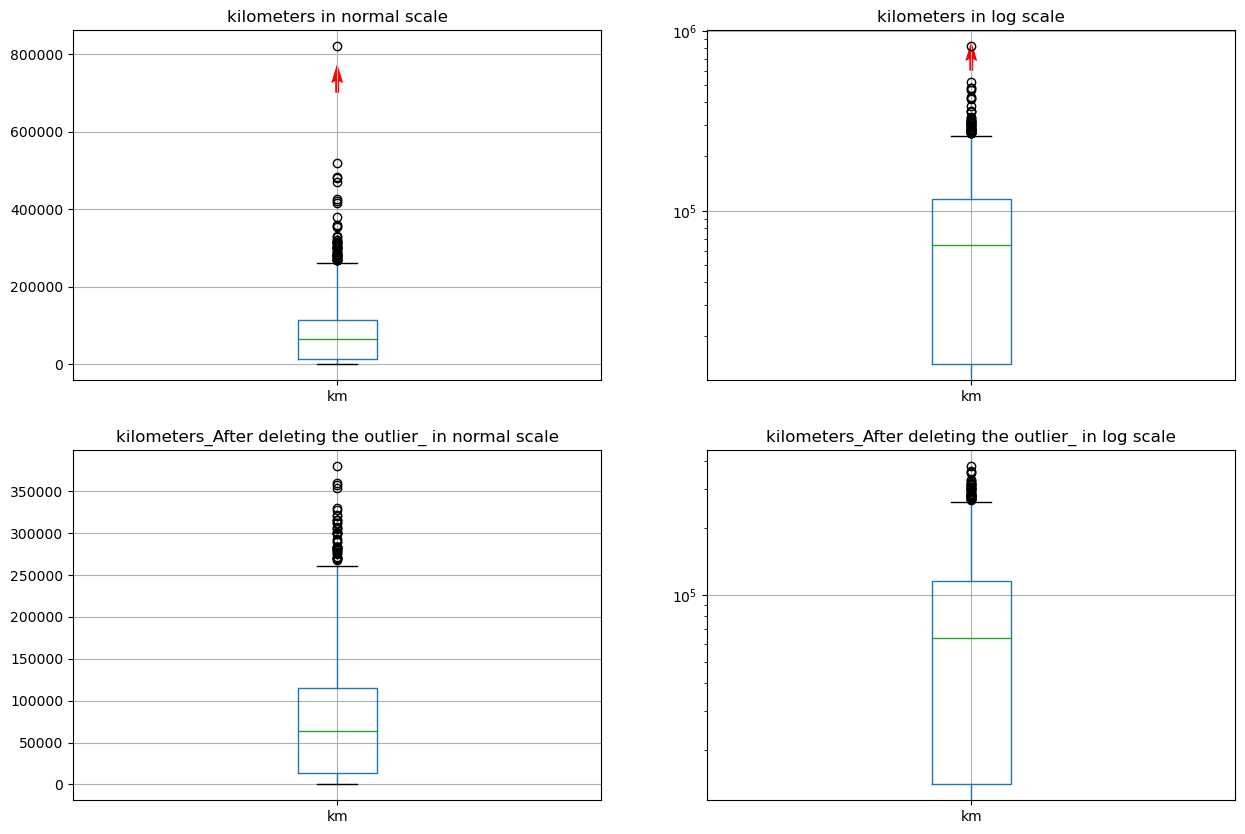

In [40]:
fig=plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
used_Cars[["km"]].boxplot()
plt.quiver(1,700000,1,1500000,color="red")
plt.title("kilometers in normal scale")

plt.yscale("linear")

plt.subplot(2,2,2)
used_Cars[["km"]].boxplot()
plt.quiver(1,600000,1,1000000,color="red")
plt.title("kilometers in log scale")
plt.yscale("log")

print("The deleted record:\n",used_Cars[used_Cars.km>400000],sep="")
used_Cars.drop(used_Cars[used_Cars.km>400000].index,inplace=True)

plt.subplot(2,2,3)
used_Cars[["km"]].boxplot()
plt.title("kilometers_After deleting the outlier_ in normal scale")
plt.yscale("linear")


plt.subplot(2,2,4)
used_Cars[["km"]].boxplot()
plt.title("kilometers_After deleting the outlier_ in log scale")
plt.yscale("log")

> - the km is right skewed with only one outlier at over 800000
> - the rest of the outlies are **accepted** real values that could be managed by scaling the feature

### **years**
- here I noticed that there are very old cars with a high price and that might be misleading to the actual model since the general idea would give that :
    - "***the newer the car the highest is the price***"

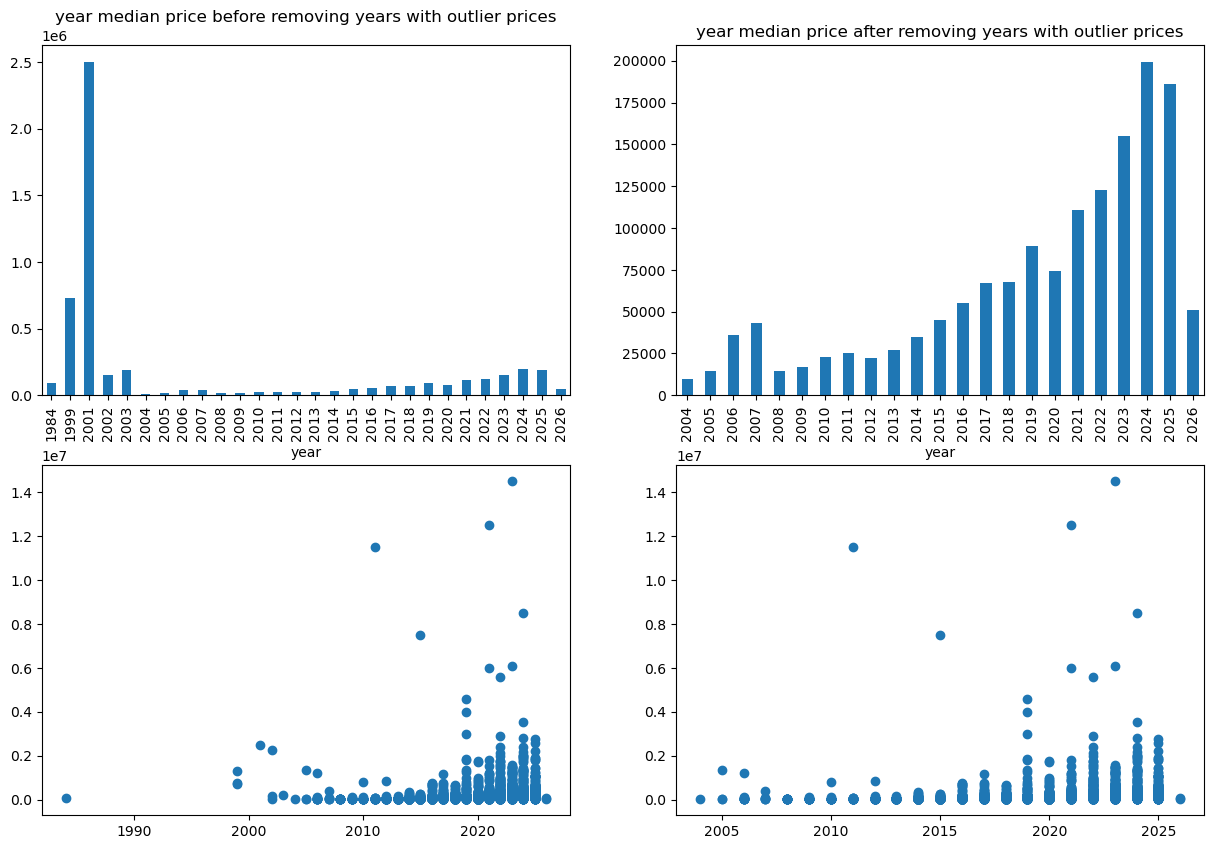

In [41]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
used_Cars.groupby(by="year")["price"].median().plot(kind="bar")
plt.title("year median price before removing years with outlier prices")
plt.subplot(2,2,2)
used_Cars.drop(used_Cars[used_Cars["year"]<2004].index).groupby(by="year")["price"].median().plot(kind="bar")
plt.title("year median price after removing years with outlier prices")
plt.subplot(2,2,3)
plt.scatter(used_Cars.year,used_Cars.price)
plt.subplot(2,2,4)
plt.scatter(used_Cars.drop(used_Cars[used_Cars["year"]<2004].index).year,used_Cars.drop(used_Cars[used_Cars["year"]<2004].index).price)

> - here it doesn't make sense to have a care in 2026 and we are in 2025! --> so it will be deleted
> - beside the very old values before 2004 are not acceptable and might miss lead the model since they are few and have a higher price --> will also be deleted

suggestion for future me:
- use standard scaling not MinMax

In [42]:
used_Cars=used_Cars.drop(used_Cars[used_Cars["year"]<2004].index).drop(used_Cars[used_Cars["year"]>2025].index)
used_Cars.describe()

,year,km,manual,price
count,3144.000000,3144.000000,3144.000000,3.144000e+03
mean,2020.049618,74381.067748,0.005407,2.150200e+05
std,3.958272,67234.343479,0.073346,5.686870e+05
min,2004.000000,0.000000,0.000000,7.000000e+03
25%,2017.000000,14000.000000,0.000000,4.800000e+04
50%,2021.000000,64000.000000,0.000000,9.495000e+04
75%,2023.000000,115000.000000,0.000000,1.990000e+05
max,2025.000000,380000.000000,1.000000,1.450000e+07


### analyzing the ***price***
- this was done for exploration purposes 

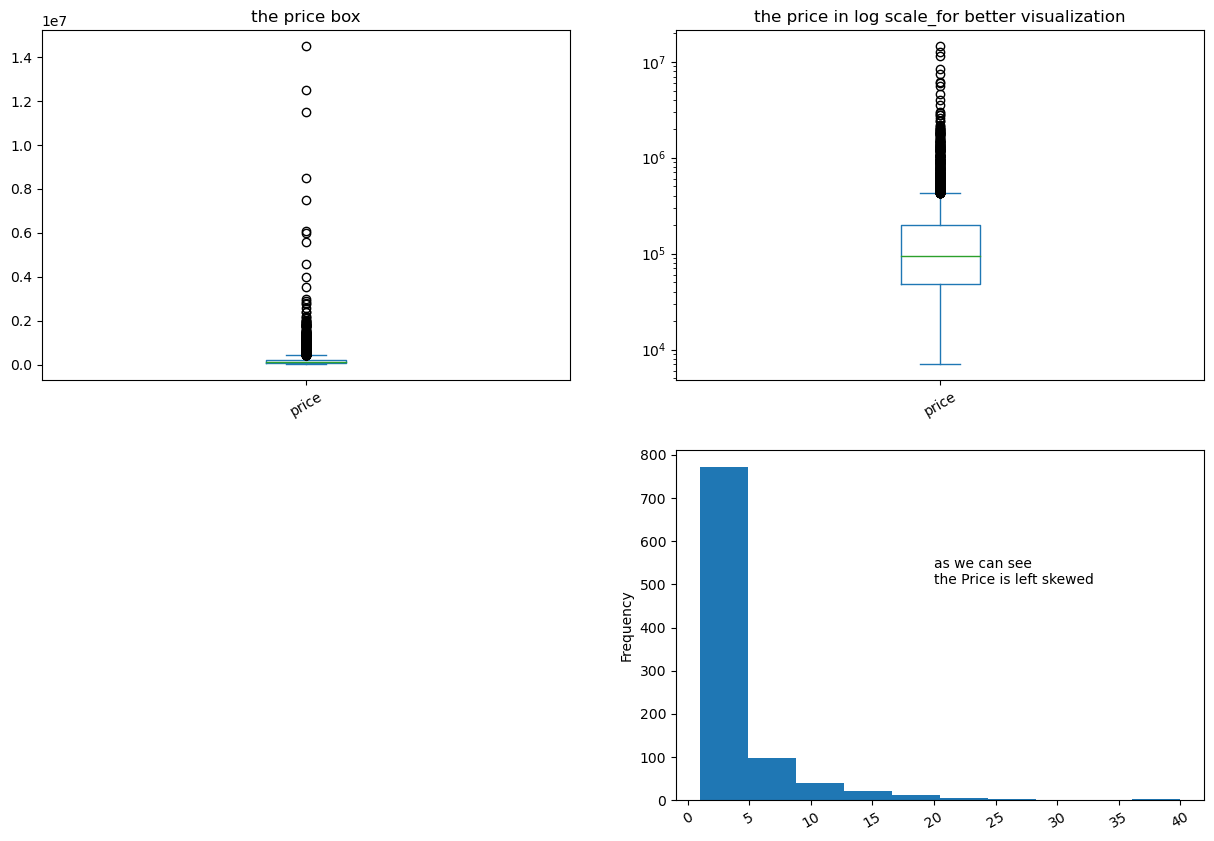

In [43]:
fig=plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
used_Cars.price.plot(kind="box")
plt.title('the price box')
plt.xticks(rotation=30)
plt.autumn()

plt.subplot(2,2,2)
used_Cars.price.plot(kind="box")
plt.title('the price in log scale_for better visualization')
plt.xticks(rotation=30);
plt.yscale("log")

plt.subplot(2,2,4)
used_Cars[["price"]].value_counts().plot(kind="hist")
plt.annotate("as we can see \nthe Price is left skewed",(20,500))
plt.xticks(rotation=30);
plt.yscale("linear")



> - <div style="color:#ff1a40;background-color:Black;width:fit-content;"><strong>There are alot of outlieres that might misslead the model!!!</strong></div>

## ***getting to see categories wih the highest prices***

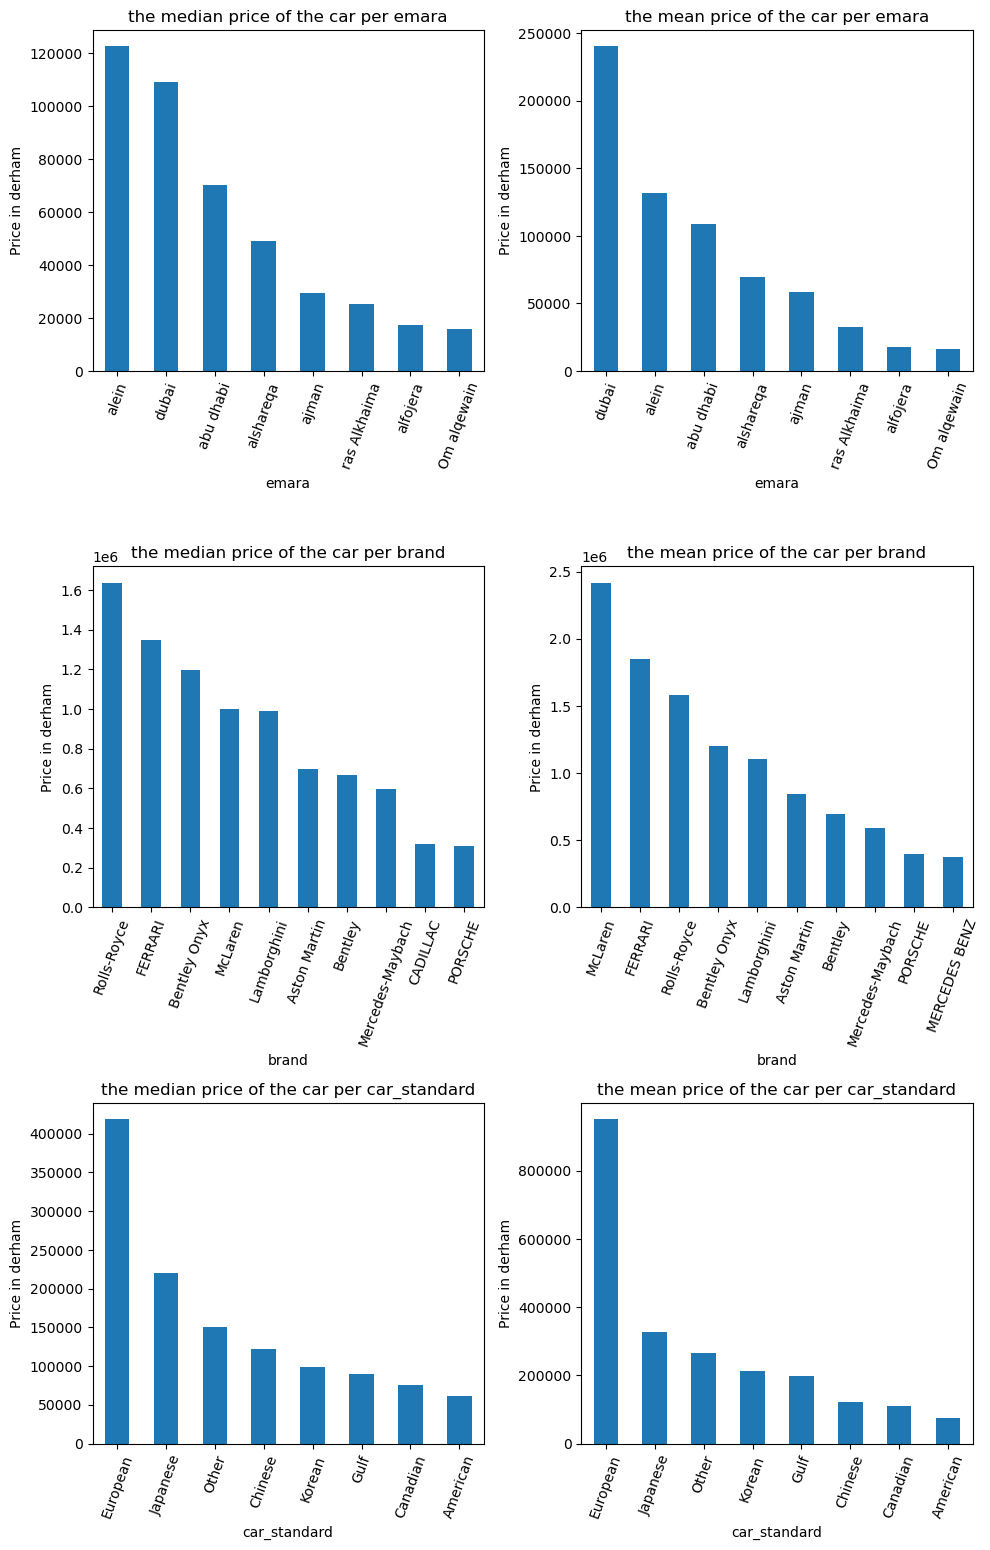

In [44]:
features=["emara","brand","car_standard"]
fig=plt.figure(figsize=(10,20))
for ind,la in enumerate(features):
    plt.subplot(len(features)+1,2,ind*2+1)
    used_Cars.groupby(la)["price"].median().sort_values(ascending=False)[:10].plot(kind="bar")
    plt.title(f'the median price of the car per {la}')
    plt.xticks(rotation=70)
    plt.ylabel("Price in derham")
    plt.subplot(len(features)+1,2,ind*2+2)
    used_Cars.groupby(la)["price"].mean().sort_values(ascending=False)[:10].plot(kind="bar")
    plt.title(f'the mean price of the car per {la}')
    plt.xticks(rotation=70);
    plt.ylabel("Price in derham")
    plt.tight_layout()

## ***Category encoding :***

### **Brand encoding**

In [45]:
#=======I run this code once to get the json file======================================================================
# brand_stats = used_Cars.groupby('brand')['price'].agg(['count', 'mean', 'median']).reset_index().sort_values('mean')

# quantiles = brand_stats['mean'].quantile([0.25, 0.5, 0.75]).to_dict()

# def assign_tier(mean_price):
#     if mean_price >= quantiles[0.75]:
#         return 'Luxury'
#     elif mean_price >= quantiles[0.5]:
#         return 'Premium'
#     elif mean_price >= quantiles[0.25]:
#         return 'Mid'
#     else:
#         return 'Economy'

# brand_stats['tier'] = brand_stats['mean'].apply(assign_tier)
# brand_tier_dict = dict(zip(brand_stats['brand'], brand_stats['tier']))
# output_path = 'brand_tier_dict.json'
# with open(output_path, 'w') as f:
#     json.dump(brand_tier_dict, f, indent=2)

In [46]:
with open('brand_tier_dict.json', 'r') as f:
    brand_tier_dict = json.load(f)
    
BrandDummies = pd.get_dummies(used_Cars['brand'].map(brand_tier_dict).fillna('Other'), prefix='Brand', prefix_sep='_',dtype=int)
BrandDummies.sum().sort_values()
# df = pd.concat([used_Cars, BrandDummies,pd.get_dummies(used_Cars[])], axis=1)
# df

Brand_Economy     570
Brand_Mid         608
Brand_Luxury      890
Brand_Premium    1076
dtype: int64

> the car may not be in the dictionary I made meaning that we don't know it's category so it would be none of the above which is other (all of the cats are zero)

### Creating the data that could be used in WEKA:

In [47]:
WekaData=used_Cars.copy()
WekaData["BrandTire"]=used_Cars['brand'].map(brand_tier_dict).fillna('Other')
WekaData.drop("brand",axis=1,inplace=True)
WekaData.drop(["model","car_type"],axis=1).to_csv("Dubizzle_UsedCars_WekaData.csv",index=False, encoding="utf-8")
WekaData.head()


,emara,model,car_type,year,km,manual,car_standard,steering_side,price,BrandTire
0,dubai,S06,Other,2025,15,0,Gulf,LEFT,69000,Mid
1,dubai,Yuan up,Other,2025,0,0,Chinese,LEFT,62000,Premium
2,dubai,Q3,35 TFSI Quattro,2015,160000,0,Gulf,LEFT,34000,Premium
3,alshareqa,سَني,Base,2021,119000,0,Gulf,LEFT,22000,Mid
4,alshareqa,7 - السلسلة,740Li xDrive,2018,183000,0,Gulf,LEFT,85000,Luxury


### **Car Standard Encoding**

In [48]:
StandardDummies = pd.get_dummies(used_Cars.car_standard, prefix='Standard', prefix_sep='_',dtype=int).drop("Standard_Other",axis=1)
StandardDummies

,Standard_American,Standard_Canadian,Standard_Chinese,Standard_European,Standard_Gulf,Standard_Japanese,Standard_Korean
0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
3158,0,0,0,0,1,0,0
3159,0,0,0,0,1,0,0
3160,1,0,0,0,0,0,0
3161,0,0,0,0,1,0,0


> if all of them are 0 then the category is "Other" so I deleted it 

### **Emara encoding**

In [49]:
EmaraDummies = pd.get_dummies(used_Cars.emara, prefix='Emara', prefix_sep='_',dtype=int)
EmaraDummies.sum()

Emara_Om alqewain        1
Emara_abu dhabi        161
Emara_ajman             42
Emara_alein              4
Emara_alfojera           1
Emara_alshareqa        286
Emara_dubai           2645
Emara_ras Alkhaima       4
dtype: int64

<Axes: >

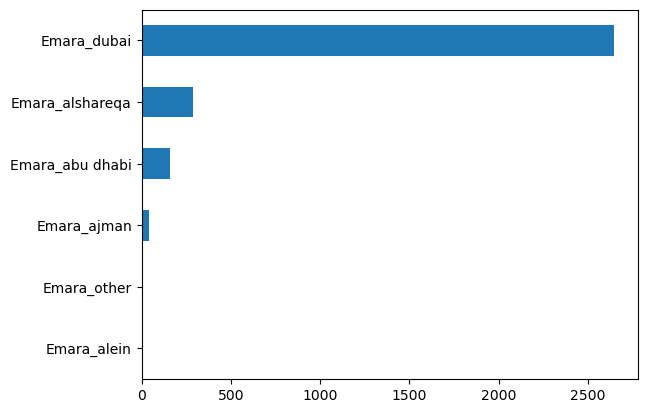

In [50]:
EmaraDummies["Emara_other"]=EmaraDummies[["Emara_Om alqewain","Emara_ras Alkhaima","Emara_alfojera"]].sum(axis=1)
EmaraDummies=EmaraDummies.drop(["Emara_Om alqewain","Emara_ras Alkhaima","Emara_alfojera"],axis=1)
EmaraDummies.sum().sort_values().plot(kind="barh")

### **steering_side encoding**

In [51]:
used_Cars['steering_side']=[1 if x=="LEFT" else 0 for x in used_Cars.steering_side]
used_Cars.head()

,emara,brand,model,car_type,year,km,manual,car_standard,steering_side,price
0,dubai,SOUEAST,S06,Other,2025,15,0,Gulf,1,69000
1,dubai,BYD,Yuan up,Other,2025,0,0,Chinese,1,62000
2,dubai,Audi,Q3,35 TFSI Quattro,2015,160000,0,Gulf,1,34000
3,alshareqa,Nissan,سَني,Base,2021,119000,0,Gulf,1,22000
4,alshareqa,BMW,7 - السلسلة,740Li xDrive,2018,183000,0,Gulf,1,85000


### ***Updating the dataSet with dummies***

<Axes: >

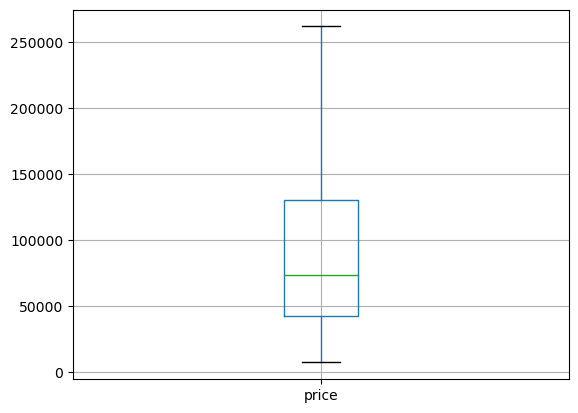

In [52]:
used_Cars[used_Cars.price<263000][["price"]].boxplot()

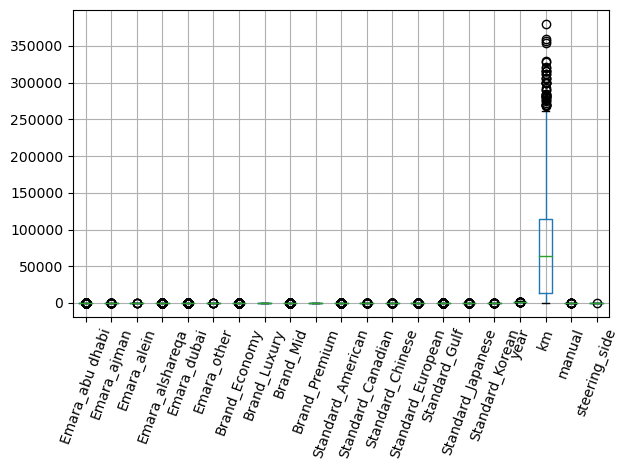

In [54]:
dataset=pd.concat([EmaraDummies,BrandDummies,StandardDummies,used_Cars.year,used_Cars.km,used_Cars.manual,used_Cars.steering_side,used_Cars.price],axis=1)
dataset.to_csv("DataSetNoOutLier.csv")
dataset.drop(["price"],axis=1).boxplot()
plt.xticks(rotation=70);
plt.tight_layout()

# ***Predicting the Car Price***

## **models and metrics**

In [2]:
MODELS={"Huber":HuberRegressor,
        "ElasticNet":ElasticNet,
        "Lesso":Lasso,
        "Ridge":Ridge,
        "Linear_Regression":LinearRegression,

        "DecisionTree":DecisionTreeRegressor,
        "ExtraTree":ExtraTreeRegressor,

        "SVR":SVR,
        
        "GradientBoosting":GradientBoostingRegressor,
        "HistGradientBoosting":HistGradientBoostingRegressor,
        "AdaBoost":AdaBoostRegressor,
        "RandomForest":RandomForestRegressor,
        "Bagging":BaggingRegressor,
        "ExtraTrees":ExtraTreesRegressor,
        "GaussianProcess":GaussianProcessRegressor,
        "neural_networkMLP":MLPRegressor,
        }


In [3]:
def REG_EvalMetrics(Y,Y_pred):
    e=Y-Y_pred
    n=len(Y)
    result={
    "R2":metrics.r2_score(Y,Y_pred),
    "mean_error":np.sum(e)/n,
    "Mean_Abs_Error":metrics.mean_absolute_error(Y,Y_pred),
    "Root_Mean_Squared_Error":np.sqrt(sum(e**2)/n),
    "Mean_Percentage_error":100*np.sum(e/Y)/n,
    "Mean_Abs_Percentage_error":metrics.mean_absolute_percentage_error(Y,Y_pred)}
    return result


#I made this DataFrame to record all of the results inside of it
EvalMetrics=["R2","mean_error","Mean_Abs_Error","Root_Mean_Squared_Error","Mean_Percentage_error","Mean_Abs_Percentage_error"]

In [4]:
def croos_val_Models(x,y,models:dict, normalize=False, columns_to_scale=None,n=5,Reg=True): 
    '''I made this to not repeat this code each time I see the best model'''   
    
    Results = pd.DataFrame(columns=["R2","Mean_Abs_Error","Mean_squared_error","rmse","median_abs_err","mean_abs_percentage_err","explained_var","max_error"]) if Reg else pd.DataFrame(columns=["accuracy","precision","recall","f1","f1_weighted"])
    
    for Name, Mo in models.items():
        if normalize and columns_to_scale is not None:
            # Build preprocessor
            preprocessor = ColumnTransformer(
                transformers=[
                    ('scale', StandardScaler(), columns_to_scale)],
                remainder='passthrough'  # leave other columns as is
            )
            # Build pipeline: preprocessor + model
            pipeline = Pipeline([
                ('pre', preprocessor),
                ('model', Mo())
            ])
        else:
            # No normalization, just use model directly
            pipeline = Mo()
        
        # Calculate metrics
        if Reg:
            r2 = cross_val_score(pipeline, x, y, cv=n, scoring="r2", n_jobs=-1).mean()
            mae = -cross_val_score(pipeline, x, y, cv=n, scoring="neg_mean_absolute_error", n_jobs=-1).mean()
            mse = -cross_val_score(pipeline, x, y, cv=n, scoring="neg_mean_squared_error", n_jobs=-1).mean()
            rmse = (-cross_val_score(pipeline, x, y, cv=n, scoring="neg_root_mean_squared_error", n_jobs=-1).mean())
            medianAe = -cross_val_score(pipeline, x, y, cv=n, scoring="neg_median_absolute_error", n_jobs=-1).mean()
            mape = -cross_val_score(pipeline, x, y, cv=n, scoring="neg_mean_absolute_percentage_error", n_jobs=-1).mean()
            ev = cross_val_score(pipeline, x, y, cv=n, scoring="explained_variance", n_jobs=-1).mean()
            max_err = cross_val_score(pipeline, x, y, cv=n, scoring="max_error", n_jobs=-1).mean()

            Results.loc[Name] = [r2, mae, mse, rmse, medianAe, mape, ev, max_err]
        else:
            accuracy = cross_val_score(pipeline, x, y, cv=n, scoring="accuracy", n_jobs=-1).mean()
            precision = -cross_val_score(pipeline, x, y, cv=n, scoring="precision_macro", n_jobs=-1).mean()
            recall = -cross_val_score(pipeline, x, y, cv=n, scoring="recall_macro", n_jobs=-1).mean()
            f1 = (-cross_val_score(pipeline, x, y, cv=n, scoring="f1_macro", n_jobs=-1).mean())
            f1_weighted = -cross_val_score(pipeline, x, y, cv=n, scoring="f1_weighted", n_jobs=-1).mean()

            Results.loc[Name] = [accuracy, precision, recall, f1, f1_weighted]
            

    return Results

In [5]:
dataset=pd.read_csv("DataSetNoOutLier.csv",index_col="Unnamed: 0")
dataset.head()

,Emara_abu dhabi,Emara_ajman,Emara_alein,Emara_alshareqa,Emara_dubai,Emara_other,Brand_Economy,Brand_Luxury,Brand_Mid,Brand_Premium,...,Standard_Chinese,Standard_European,Standard_Gulf,Standard_Japanese,Standard_Korean,year,km,manual,steering_side,price
0,0,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,2025,15,0,1,69000
1,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,2025,0,0,1,62000
2,0,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,2015,160000,0,1,34000
3,0,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,2021,119000,0,1,22000
4,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,2018,183000,0,1,85000


## **experiment 1**
- normalization effect with the effect of hard to predict target

### ***part1*** :no normalization 

In [20]:
target='price'
features =dataset.drop("price",axis=1)
Y=dataset[target]
X=features
x_train,x_validate,y_train,y_validate=train_test_split(X,Y,test_size=0.2,random_state=123)

In [22]:
NoNormalization_CroosVal=croos_val_Models(X,Y,MODELS)

In [21]:
NoNormalization=pd.DataFrame(columns=EvalMetrics)
for Name,Mo in MODELS.items():
    m=Mo()
    m.fit(x_train,y_train)
    Predict1=m.predict(x_validate)
    NoNormalization.loc[Name]=REG_EvalMetrics(y_validate,Predict1)

In [24]:
NoNormalization_CroosVal.sort_values(by="Mean_Abs_Error")

,R2,Mean_Abs_Error,Mean_squared_error,rmse,median_abs_err,mean_abs_percentage_err,explained_var,max_error
RandomForest,-0.227186,132841.134754,2.871580e+11,491220.284247,34244.047083,0.626095,-0.145748,-7.330226e+06
ExtraTrees,-0.309080,132855.163999,2.972036e+11,515407.536733,35142.494000,0.624109,-0.367340,-7.406947e+06
HistGradientBoosting,0.194154,133307.183313,2.571199e+11,444031.681624,39812.287271,0.728227,0.202175,-5.860808e+06
Bagging,-0.079685,135043.598700,2.671586e+11,486499.413810,34845.361452,0.636599,-0.101553,-7.705016e+06
GradientBoosting,-1.089696,140564.951283,3.627901e+11,566892.298229,41536.125695,0.731564,-1.078515,-8.873858e+06
DecisionTree,-0.797131,145407.202870,3.489681e+11,559627.713469,37825.025000,0.685513,-0.788623,-8.447440e+06
Huber,0.034249,146704.032027,3.180819e+11,492851.781529,51309.103573,0.842975,0.086198,-6.831022e+06
ExtraTree,-1.090767,155505.248693,3.572696e+11,550290.845183,37810.000000,0.724112,-1.073188,-8.287440e+06
SVR,-0.087226,166552.044195,3.376334e+11,514960.178481,58791.689773,1.033833,0.000590,-6.928125e+06
Ridge,0.196645,172753.349722,2.758292e+11,452291.949365,94282.386882,1.704992,0.215216,-6.179151e+06


In [26]:
NoNormalization.sort_values(by="Mean_Abs_Error")

,R2,mean_error,Mean_Abs_Error,Root_Mean_Squared_Error,Mean_Percentage_error,Mean_Abs_Percentage_error
ExtraTrees,0.411912,22474.619175,133231.589299,665381.561374,-31.380892,0.572343
RandomForest,0.325070,27412.612180,137870.501890,712818.682317,-32.399459,0.563991
Bagging,0.264100,35115.342064,143237.273517,744319.021956,-33.846701,0.592920
ExtraTree,0.390360,20890.669190,143723.877379,677464.212781,-31.766549,0.633470
HistGradientBoosting,0.259173,38795.906517,144054.708543,746806.367869,-50.790141,0.826858
GradientBoosting,0.199563,38773.741173,145144.554730,776270.917387,-36.321788,0.641170
DecisionTree,0.242090,24094.307833,154677.815546,755367.847827,-30.593674,0.630814
Huber,-0.000777,119693.851523,168475.482630,867997.299318,-34.107778,0.808828
SVR,-0.025226,138239.294672,183082.095579,878536.044415,-51.821526,1.004136
Ridge,0.104312,21374.031985,186060.816605,821160.386699,-47.619847,1.447105


#### seeing the **error graph** for the best model
- **RandomForest**

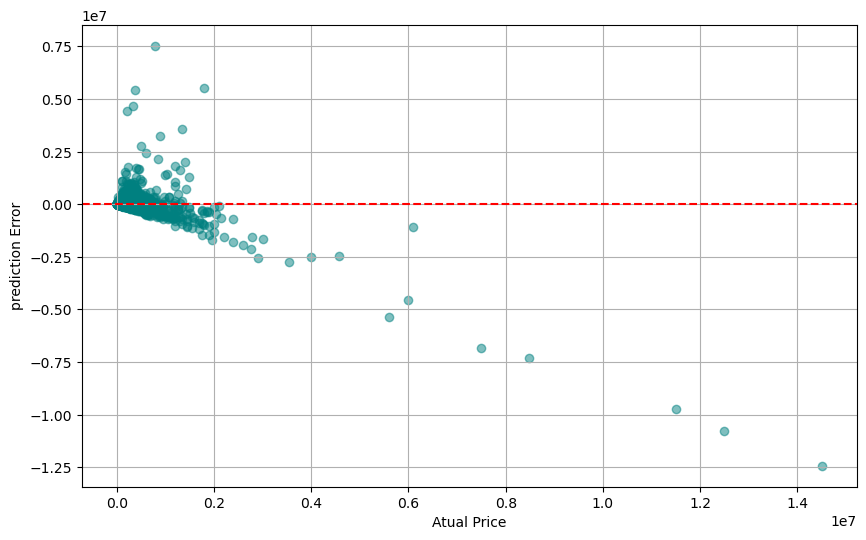

In [27]:
Y_Pred=cross_val_predict(MODELS['RandomForest'](),X,Y,cv=5)
y_pred=Y_Pred
y_true=Y
error=y_pred-y_true
plt.figure(figsize=(10,6))
plt.scatter(y_true,error,alpha=0.5,color='teal')
plt.axhline(0,color="red",linestyle="--")

plt.xlabel("Atual Price")
plt.ylabel("prediction Error")
plt.grid(True)

In [28]:
REG_EvalMetrics(y_true,y_pred)

{'R2': 0.11743875138440074,
 'mean_error': -4744.763155131234,
 'Mean_Abs_Error': 131166.73569619723,
 'Root_Mean_Squared_Error': 533634.116965675,
 'Mean_Percentage_error': -37.26865987619974,
 'Mean_Abs_Percentage_error': 0.6240312489388624}

> the problem with this model is that it tends to underestimate the higher prices and 

### ***Part2***: with normalization 
---

In [29]:
EXP1_yearTrans=StandardScaler()
EXP1_kmScaler=StandardScaler()
target='price'
features =dataset.drop(["price"],axis=1)
Y=dataset[target]
X=features
x_train,x_validate,y_train,y_validate=train_test_split(X,Y,test_size=0.2,random_state=123)

x_train[["year"]]=EXP1_yearTrans.fit_transform(x_train[["year"]])
x_train[["km"]]=EXP1_kmScaler.fit_transform(x_train[["km"]])
x_validate[["year"]]=EXP1_yearTrans.transform(x_validate[["year"]])
x_validate[["km"]]=EXP1_kmScaler.transform(x_validate[["km"]])

In [30]:
Normalized_CroosVal=croos_val_Models(X,Y,MODELS,normalize=True,columns_to_scale=["km","year"]) # for each fold it applies the stadrization and then it fit the model

In [32]:
Normalized=pd.DataFrame(columns=EvalMetrics)
for Name,Mo in MODELS.items():
    m=Mo()
    m.fit(x_train,y_train)
    Predict1=m.predict(x_validate)
    Normalized.loc[Name]=REG_EvalMetrics(y_validate,Predict1)

In [33]:
Normalized_CroosVal.sort_values(by="Mean_Abs_Error")

,R2,Mean_Abs_Error,Mean_squared_error,rmse,median_abs_err,mean_abs_percentage_err,explained_var,max_error
Huber,0.145928,1.296269e+05,2.967874e+11,4.693180e+05,44185.140760,0.745433,0.176082,-6.668744e+06
Bagging,-0.300931,1.314976e+05,2.857653e+11,5.315115e+05,35249.880000,0.632824,-0.227723,-7.569290e+06
HistGradientBoosting,0.194154,1.333072e+05,2.571199e+11,4.440317e+05,39812.287271,0.728227,0.202175,-5.860808e+06
RandomForest,-0.268475,1.335962e+05,2.844069e+11,5.017221e+05,34358.227475,0.633376,-0.367631,-7.382674e+06
ExtraTrees,-0.376002,1.339354e+05,3.002268e+11,5.087242e+05,34784.655000,0.629447,-0.371528,-7.374357e+06
GradientBoosting,-1.093660,1.408113e+05,3.627688e+11,5.674012e+05,41538.738850,0.731242,-1.075127,-8.873941e+06
DecisionTree,-0.794013,1.453169e+05,3.466689e+11,5.507913e+05,37480.475000,0.673200,-0.792230,-8.519440e+06
ExtraTree,-1.198098,1.473094e+05,3.565830e+11,5.404848e+05,38194.900000,0.707416,-1.319969,-6.337110e+06
ElasticNet,0.163128,1.665354e+05,2.918318e+11,4.648068e+05,104182.942286,1.543738,0.175952,-6.604730e+06
SVR,-0.087361,1.666293e+05,3.376581e+11,5.149867e+05,58770.436888,1.036259,0.000412,-6.928188e+06


In [34]:
Normalized.sort_values(by="Mean_Abs_Error")

,R2,mean_error,Mean_Abs_Error,Root_Mean_Squared_Error,Mean_Percentage_error,Mean_Abs_Percentage_error
ExtraTrees,0.408914,2.159150e+04,1.331128e+05,6.670757e+05,-31.547967,0.574767
RandomForest,0.310997,2.669109e+04,1.385820e+05,7.202118e+05,-32.588203,0.568715
Bagging,0.217815,3.593593e+04,1.411509e+05,7.673694e+05,-32.867318,0.577742
GradientBoosting,0.202090,4.059890e+04,1.435623e+05,7.750446e+05,-32.989476,0.625618
HistGradientBoosting,0.259173,3.879591e+04,1.440547e+05,7.468064e+05,-50.790141,0.826858
ExtraTree,0.411611,2.262671e+04,1.451070e+05,6.655518e+05,-36.581032,0.701405
Huber,0.042746,9.724347e+04,1.476644e+05,8.489132e+05,-16.639262,0.692879
DecisionTree,0.240138,2.369383e+04,1.533691e+05,7.563399e+05,-30.113568,0.616515
SVR,-0.025204,1.380295e+05,1.831259e+05,8.785267e+05,-52.247536,1.007413
ElasticNet,0.052218,2.305696e+04,1.837562e+05,8.447027e+05,-118.956101,1.437039


#### seeing the **error graph** for the best model
- **RandomForest** in cross validation

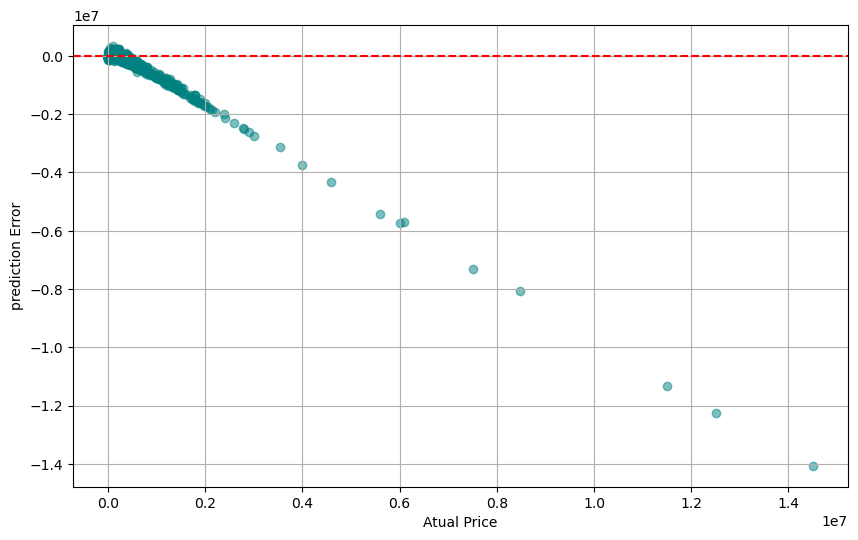

In [35]:

pipeline = Pipeline([
    ('pre', ColumnTransformer(
    transformers=[('scale', MinMaxScaler(), ["year","km"])],
    remainder='passthrough')),
    ('model',MODELS['Huber']())
])

exp1_1_Y_Pred=cross_val_predict(pipeline,X,Y,cv=5)
y_pred=exp1_1_Y_Pred
y_true=Y
error=y_pred-y_true
plt.figure(figsize=(10,6))
plt.scatter(y_true,error,alpha=0.5,color='teal')
plt.axhline(0,color="red",linestyle="--")

plt.xlabel("Atual Price")
plt.ylabel("prediction Error")
plt.grid(True)

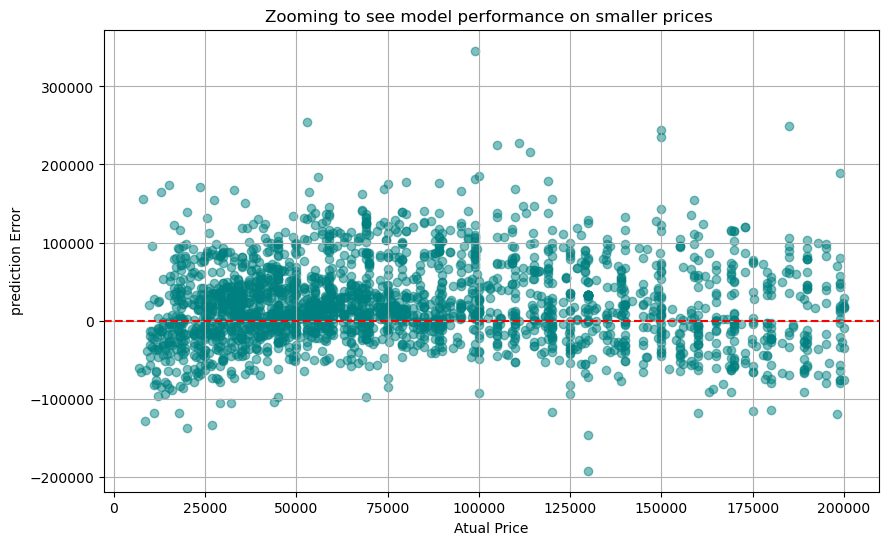

In [36]:

filter=y_true<200000
plt.figure(figsize=(10,6))
plt.scatter(y_true[filter],error[filter],alpha=0.5,color='teal')
# plt.scatter(y_true[filter],y_pred[filter],alpha=0.5,color='teal')
plt.axhline(0,color="red",linestyle="--")

plt.xlabel("Atual Price")
plt.ylabel("prediction Error")
plt.title("Zooming to see model performance on smaller prices ")
plt.grid(True)

In [37]:
REG_EvalMetrics(y_true,y_pred)

{'R2': 0.07907417694839247,
 'mean_error': 80069.4729287651,
 'Mean_Abs_Error': 129327.90185925164,
 'Root_Mean_Squared_Error': 545109.1673415641,
 'Mean_Percentage_error': -11.442589204264582,
 'Mean_Abs_Percentage_error': 0.7195546916656373}

> the problem with this model is that it tends to underestimate the higher prices and over estimate the lower prices

### **EXP1 results**
> - ***part1***
>    - *CrossValidation:*
>       - the best MAE with cross validation was ***133513*** with ***random forest*** algorithm 
>       - the best R² was **0.19664** with ***Lesso*** regression
>    - SplitPredict validation:
>       - the best MAE with cross validation was ***128373.295*** with ***random forest*** algorithm 
>       - the best R² was **0.40223** with ***Extra Trees*** regression
> ---
> - ***part2*** 
>    - *CrossValidation:*
>       - the best MAE with cross validation was ***128293*** with ***random forest*** algorithm 
>       - the best R² was **0.196678** with ***Ridge*** regression
>    - SplitPredict validation:
>       - the best MAE with cross validation was ***131990*** with ***ExtraTrees*** algorithm 
>       - the best R² was **0.41352** with ***Extra Trees*** regression
>
> the results are slightly improved but still bad 
>
> `Notice that the problem is with the Price huge outliers values`
>
> in the next section I would explore solutions and try to improve the model performance

## <div style="color:orange;background-color:black;padding:10px">***Solving the price Outliers problem***</div>

####
- <strong style="color:lightgreen;background-color:black;padding:10px;">2 Data sets with 2 deferent models</strong>

    - one for >260k UAD cars (expinsive Cars)
    - another for <260k UAD cars (normal prices Cars)
> here the model that would be done is based on 82% of the data 

In [38]:
threshold=1.33
print(f"{round(dataset[dataset.price>dataset.price.quantile(.75)*threshold].shape[0] /dataset.shape[0],2)}%")
dataset[dataset.price>dataset.price.quantile(.75)*threshold].price.min()# can't delete them since they are more =1/4 of the data 

0.18%


264900

In [41]:
print(dataset[dataset.price>263000].shape[0],"record of outliers")
print(f"{round(dataset[dataset.price>263000].shape[0] /dataset.shape[0],2)}%")

# the number was chosen based on the (0.75+ threshold) Quantile
No_OverPriced_Data=dataset[dataset.price<263000].copy()
Over_Priced=dataset[dataset.price>263000].copy()

570 record of outliers
0.18%


(array([1]), [Text(1, 0, 'price')])

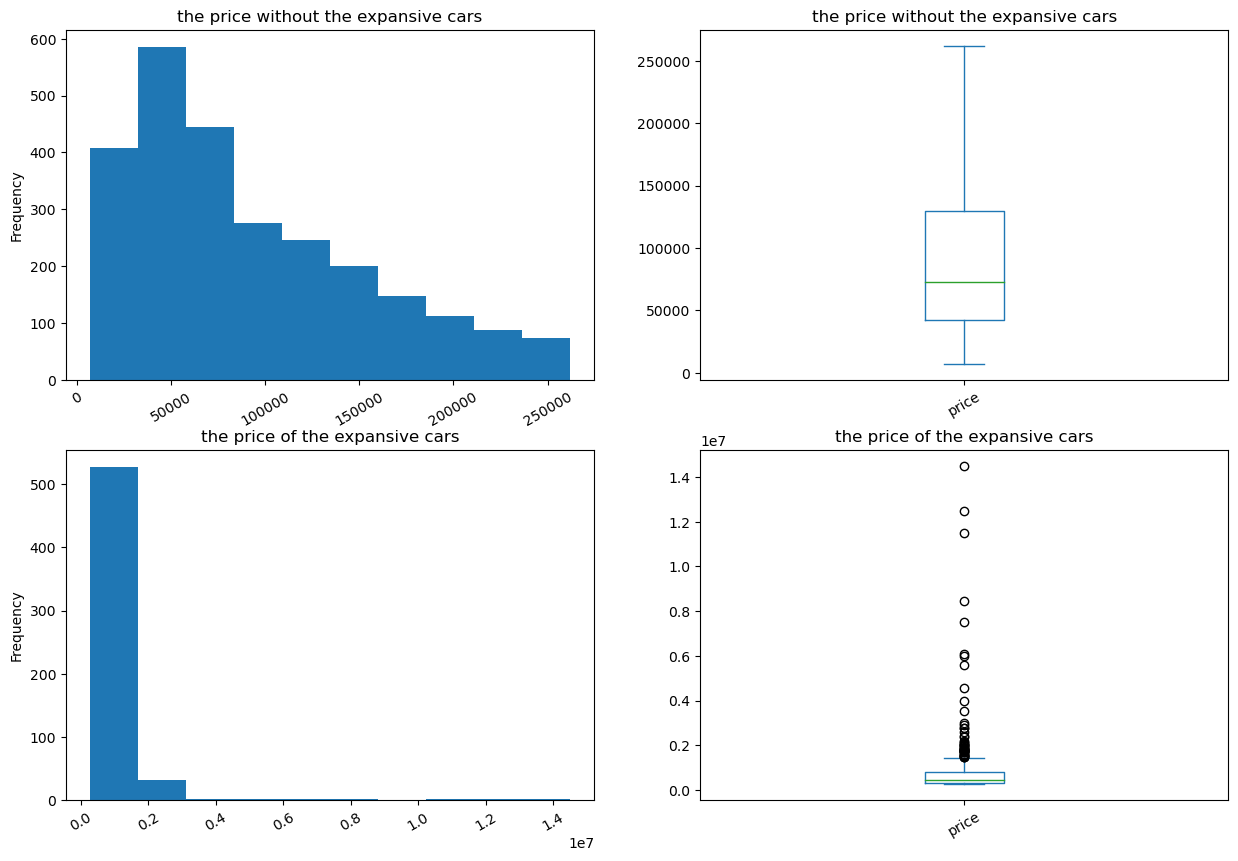

In [43]:
fig=plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
No_OverPriced_Data.price.plot(kind="hist")
plt.title('the price without the expansive cars')
plt.xticks(rotation=30)

plt.subplot(2,2,2)
No_OverPriced_Data.price.plot(kind="box");
plt.title('the price without the expansive cars')
plt.xticks(rotation=30)

plt.subplot(2,2,3)
Over_Priced.price.plot(kind="hist")
plt.title('the price of the expansive cars')
plt.xticks(rotation=30)

plt.subplot(2,2,4)
Over_Priced.price.plot(kind="box");
plt.title('the price of the expansive cars')
plt.xticks(rotation=30)


#the data is less skewed and doesn't have over prices cars


> here we can see that there are a few could rid-off points 

---
####

- <strong style="color:lightgreen;background-color:black;padding:5px;">_log transform_</strong> the target to reduce the expansive Quarter effect

In [44]:
dataset["LOG_PRICE"]=np.log(dataset.price)# this was added to try later in the model to help improve it 

(array([1]), [Text(1, 0, 'LOG_PRICE')])

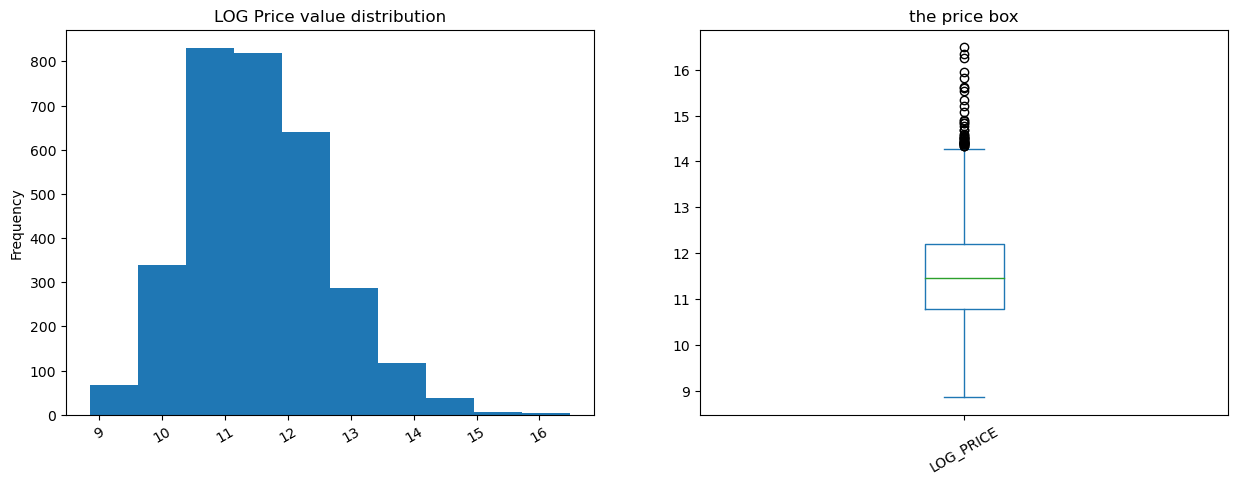

In [45]:
fig=plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
dataset.LOG_PRICE.plot(kind="hist")
plt.title('LOG Price value distribution')
plt.xticks(rotation=30)

plt.subplot(1,2,2)
dataset.LOG_PRICE.plot(kind="box");
plt.title('the price box')
plt.xticks(rotation=30)

#the data is less skewed


## **experiment 2:**
### <div style="color:orange;background-color:black;padding:10px">model with the Target _log transformed_</div>

<Axes: ylabel='Frequency'>

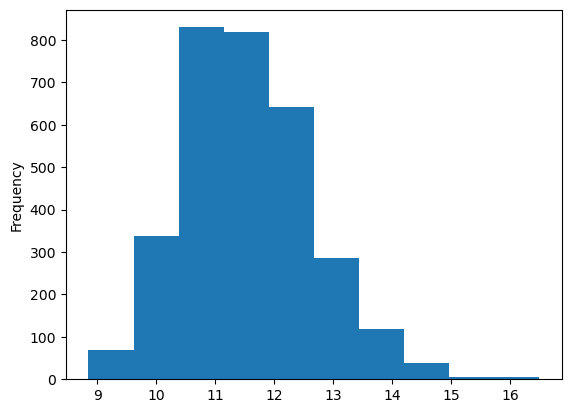

In [46]:
dataset["LOG_PRICE"].plot(kind="hist")

In [47]:
dataset.head()

,Emara_abu dhabi,Emara_ajman,Emara_alein,Emara_alshareqa,Emara_dubai,Emara_other,Brand_Economy,Brand_Luxury,Brand_Mid,Brand_Premium,...,Standard_European,Standard_Gulf,Standard_Japanese,Standard_Korean,year,km,manual,steering_side,price,LOG_PRICE
0,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,2025,15,0,1,69000,11.141862
1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,2025,0,0,1,62000,11.034890
2,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,2015,160000,0,1,34000,10.434116
3,0,0,0,1,0,0,0,0,1,0,...,0,1,0,0,2021,119000,0,1,22000,9.998798
4,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,2018,183000,0,1,85000,11.350407


In [48]:

# dataset
target='LOG_PRICE'
features =dataset.drop(["LOG_PRICE","price"],axis=1)

Y=dataset[target]
X=features
LogPrice_Cross=croos_val_Models(X,Y,MODELS,normalize=True,columns_to_scale=["km","year"])


In [49]:
EXP2_yearTrans=StandardScaler()
EXP2_kmScaler=StandardScaler()
x_train,x_validate,y_train,y_validate=train_test_split(X,Y,test_size=0.2,random_state=123)
x_train[["year"]]=EXP2_yearTrans.fit_transform(x_train[["year"]])
x_train[["km"]]=EXP2_kmScaler.fit_transform(x_train[["km"]])
x_validate[["year"]]=EXP2_yearTrans.transform(x_validate[["year"]])
x_validate[["km"]]=EXP2_kmScaler.transform(x_validate[["km"]])

LogMet=pd.DataFrame(columns=EvalMetrics)
for Name,Mo in MODELS.items():
    m=Mo()
    m.fit(x_train,y_train)
    Predict1=m.predict(x_validate)
    LogMet.loc[Name]=REG_EvalMetrics(y_validate,Predict1)

In [50]:
LogPrice_Cross.sort_values("Mean_Abs_Error")

,R2,Mean_Abs_Error,Mean_squared_error,rmse,median_abs_err,mean_abs_percentage_err,explained_var,max_error
SVR,0.714703,0.423255,0.314625,0.559624,0.338534,0.036560,7.249531e-01,-2.694212
GradientBoosting,0.709357,0.430938,0.319031,0.564035,0.345958,0.037176,7.220191e-01,-2.672633
neural_networkMLP,0.700801,0.431968,0.324286,0.574170,0.348146,0.037647,7.130043e-01,-2.773626
HistGradientBoosting,0.709960,0.432285,0.318384,0.563593,0.344132,0.037352,7.220903e-01,-2.728112
RandomForest,0.685048,0.446741,0.344774,0.586766,0.345346,0.038567,6.963713e-01,-2.728047
Huber,0.651987,0.455981,0.384609,0.618473,0.354688,0.039166,6.653627e-01,-3.235583
Bagging,0.667946,0.458755,0.366889,0.595831,0.361986,0.039474,6.823226e-01,-2.870274
Ridge,0.663205,0.461287,0.371240,0.608146,0.373726,0.039763,6.809593e-01,-2.992192
Linear_Regression,0.662419,0.461916,0.372161,0.608874,0.374083,0.039826,6.800157e-01,-2.994895
ExtraTrees,0.634314,0.472955,0.398702,0.631252,0.362733,0.040866,6.423558e-01,-2.959097


In [51]:
LogMet.sort_values("Mean_Abs_Error")

,R2,mean_error,Mean_Abs_Error,Root_Mean_Squared_Error,Mean_Percentage_error,Mean_Abs_Percentage_error
SVR,0.735050,0.002364,0.405054,0.548869,-0.203330,0.034990
HistGradientBoosting,0.732749,0.007418,0.413550,0.551247,-0.135874,0.035758
GradientBoosting,0.725561,0.013817,0.413653,0.558611,-0.097549,0.035667
RandomForest,0.725486,-0.001343,0.418432,0.558687,-0.193590,0.036147
neural_networkMLP,0.723786,0.002852,0.419149,0.560414,-0.189263,0.036164
Huber,0.678870,0.012708,0.427868,0.604264,-0.155826,0.036773
Bagging,0.718868,-0.004833,0.429449,0.565381,-0.218947,0.037145
Ridge,0.684593,-0.017132,0.435346,0.598856,-0.398676,0.037558
Linear_Regression,0.683870,-0.019695,0.436416,0.599541,-0.418239,0.037657
ExtraTrees,0.696967,-0.016021,0.438045,0.586991,-0.306694,0.038006


### comparing exp(results) with actual price

In [52]:
pipeline = Pipeline([
    ('pre', ColumnTransformer(transformers=[('scale', StandardScaler(), ["year","km"])],remainder='passthrough')
    ),
    ('model',MODELS['SVR']())
])
Y_pred_Log=cross_val_predict(pipeline,X,Y,cv=5)
y_pred=np.exp(Y_pred_Log)
y_true=np.exp(Y)
pd.DataFrame(REG_EvalMetrics(y_true,y_pred),index=["MODELwithLOG"])

,R2,mean_error,Mean_Abs_Error,Root_Mean_Squared_Error,Mean_Percentage_error,Mean_Abs_Percentage_error
MODELwithLOG,0.212105,57285.722831,109660.026676,504202.861939,-16.540071,0.471818


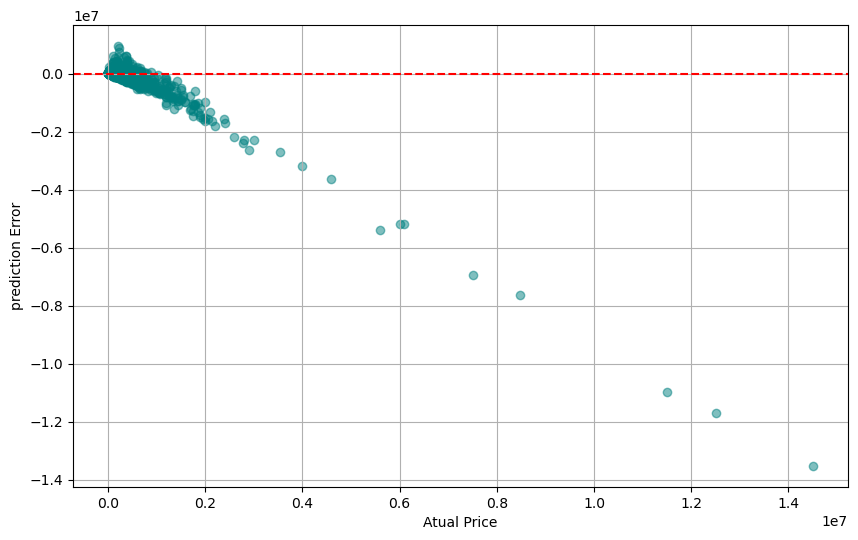

In [53]:
error=y_pred-y_true
plt.figure(figsize=(10,6))
plt.scatter(y_true,error,alpha=0.5,color='teal')
plt.axhline(0,color="red",linestyle="--")

plt.xlabel("Atual Price")
plt.ylabel("prediction Error")
plt.grid(True)

### **EXP2 results**
<div style="color:skyblue;background-color:black;padding:10px"><strong> The results was the same as the previous ones </strong><strong style="color:orange"> the LOG had no effect on the R² but slightly helped with the MAE to make it drop from 128293 to 109660</strong></div>


- the models was better at predicting logPrice and gave hight evaluations values on that value
- but when taking the exponential of the result to get the real price in (UEA) and comparing it to the actual price it was also BAD as the first experiment

## **experiment 3:**
### <div style="color:orange;background-color:black;padding:10px">repeating experiment 1 with prices less than 270k</div>

### ***reducing the dataset***

In [54]:
No_OverPriced=No_OverPriced_Data[No_OverPriced_Data.price<264900]

<Axes: >

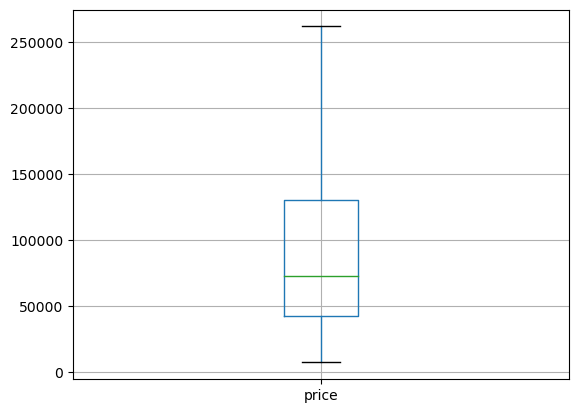

In [55]:
No_OverPriced[["price"]].boxplot()

In [56]:
EXP3_yearTrans=StandardScaler()
EXP3_kmScaler=StandardScaler()
target='price'
features =No_OverPriced.drop(["price"],axis=1)
Y=No_OverPriced[target]
X=features
x_train,x_validate,y_train,y_validate=train_test_split(X,Y,test_size=0.2,random_state=123)

x_train[["year"]]=EXP3_yearTrans.fit_transform(x_train[["year"]])
x_train[["km"]]=EXP3_kmScaler.fit_transform(x_train[["km"]])
x_validate[["year"]]=EXP3_yearTrans.transform(x_validate[["year"]])
x_validate[["km"]]=EXP3_kmScaler.transform(x_validate[["km"]])

In [57]:
exp3_CroosVal=croos_val_Models(X,Y,MODELS,normalize=True,columns_to_scale=["km","year"]) # for each fold it applies the stadrization and then it fit the model

In [58]:
exp3_split_val=pd.DataFrame(columns=EvalMetrics)
for Name,Mo in MODELS.items():
    m=Mo()
    m.fit(x_train,y_train)
    Predict1=m.predict(x_validate)
    exp3_split_val.loc[Name]=REG_EvalMetrics(y_validate,Predict1)

In [59]:
exp3_CroosVal.sort_values(by="Mean_Abs_Error")

,R2,Mean_Abs_Error,Mean_squared_error,rmse,median_abs_err,mean_abs_percentage_err,explained_var,max_error
GradientBoosting,0.577387,2.894152e+04,1.600394e+09,3.992870e+04,20721.209561,0.439749,0.590357,-1.616288e+05
HistGradientBoosting,0.568466,2.934964e+04,1.633651e+09,4.032714e+04,20896.834574,0.441723,0.581780,-1.543489e+05
RandomForest,0.536070,3.030418e+04,1.758311e+09,4.173930e+04,21351.270991,0.447608,0.548722,-1.677569e+05
Bagging,0.516334,3.130296e+04,1.859949e+09,4.299957e+04,22267.560000,0.457392,0.523610,-1.680320e+05
Huber,0.536036,3.155900e+04,1.756971e+09,4.184509e+04,24730.731986,0.513871,0.550879,-1.517394e+05
Ridge,0.538749,3.201244e+04,1.749565e+09,4.172715e+04,26102.152734,0.548205,0.550550,-1.492529e+05
Lesso,0.536516,3.208338e+04,1.757877e+09,4.182843e+04,26182.350022,0.551354,0.548169,-1.495778e+05
Linear_Regression,0.535921,3.210617e+04,1.760173e+09,4.185580e+04,26240.167939,0.551726,0.547610,-1.497306e+05
ExtraTrees,0.456594,3.248590e+04,2.051345e+09,4.518608e+04,22630.265000,0.470876,0.467010,-1.852392e+05
AdaBoost,0.489155,3.419572e+04,1.982383e+09,4.417598e+04,28680.026518,0.653643,0.510876,-1.529111e+05


In [60]:
exp3_split_val.sort_values(by="Mean_Abs_Error")

,R2,mean_error,Mean_Abs_Error,Root_Mean_Squared_Error,Mean_Percentage_error,Mean_Abs_Percentage_error
GradientBoosting,0.610024,-1021.666243,2.873769e+04,3.874157e+04,-25.626694,0.469372
HistGradientBoosting,0.604687,-962.369702,2.880743e+04,3.900576e+04,-24.182748,0.463836
RandomForest,0.536475,-59.682975,3.033909e+04,4.223716e+04,-24.442685,0.483185
Huber,0.579737,3028.711703,3.118084e+04,4.021783e+04,-14.020727,0.534804
Bagging,0.512999,207.864597,3.126912e+04,4.329353e+04,-24.657796,0.498110
Linear_Regression,0.574898,-1486.757752,3.161171e+04,4.044873e+04,-20.393736,0.569772
Ridge,0.576265,-1437.532991,3.165800e+04,4.038363e+04,-20.087789,0.569440
Lesso,0.574864,-1463.035515,3.168919e+04,4.045036e+04,-20.031356,0.570626
ExtraTrees,0.454254,-537.173895,3.221572e+04,4.583039e+04,-24.871182,0.509836
AdaBoost,0.491678,-8809.772953,3.496057e+04,4.423107e+04,-50.595697,0.673116


#### seeing the **error graph** for the best model
- **RandomForest** in cross validation

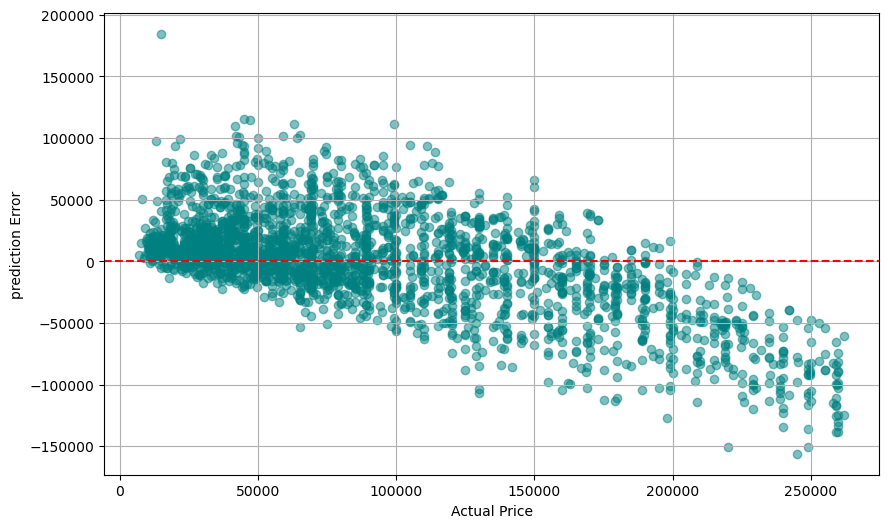

In [61]:

pipeline = Pipeline([
    ('pre', ColumnTransformer(
    transformers=[('scale', StandardScaler(), ["year","km"])],
    remainder='passthrough')),
    ('model',GradientBoostingRegressor())
])

exp1_3_Y_Pred=cross_val_predict(pipeline,X,Y,cv=20)
y_pred=exp1_3_Y_Pred
y_true=Y
error=y_pred-y_true
plt.figure(figsize=(10,6))
plt.scatter(y_true,error,alpha=0.5,color='teal')
plt.axhline(0,color="red",linestyle="--")

plt.xlabel("Actual Price")
plt.ylabel("prediction Error")
plt.grid(True)

In [62]:
REG_EvalMetrics(y_true,y_pred)

{'R2': 0.600788679530577,
 'mean_error': -56.51435677882233,
 'Mean_Abs_Error': 28754.25432355598,
 'Root_Mean_Squared_Error': 39394.63907891428,
 'Mean_Percentage_error': -22.65548839585688,
 'Mean_Abs_Percentage_error': 0.43602936003355297}

> the problem with this model is that it tends to underestimate the higher prices and over estimate the lower prices

### **EXP3 results**
> - restricting the data to have the cars that has less price than 100 helped reducing the MAE
> - but the reduction wasn't good enough to take 

|metric|   |
|-----|-----|
|R2: |60%|
|Mean_Abs_Error | 28754 AED|
|Mean_Abs_Percentage_error |43.6%|

## <div style="color:skyblue;background-color:black;padding:10px">***feature selection***

### ***Adding possible columns***

In [ ]:
current_year=datetime.now().year
dataset["car_age"]=current_year-dataset['year']
dataset["kmPerYear"]=dataset["km"]/dataset["car_age"]

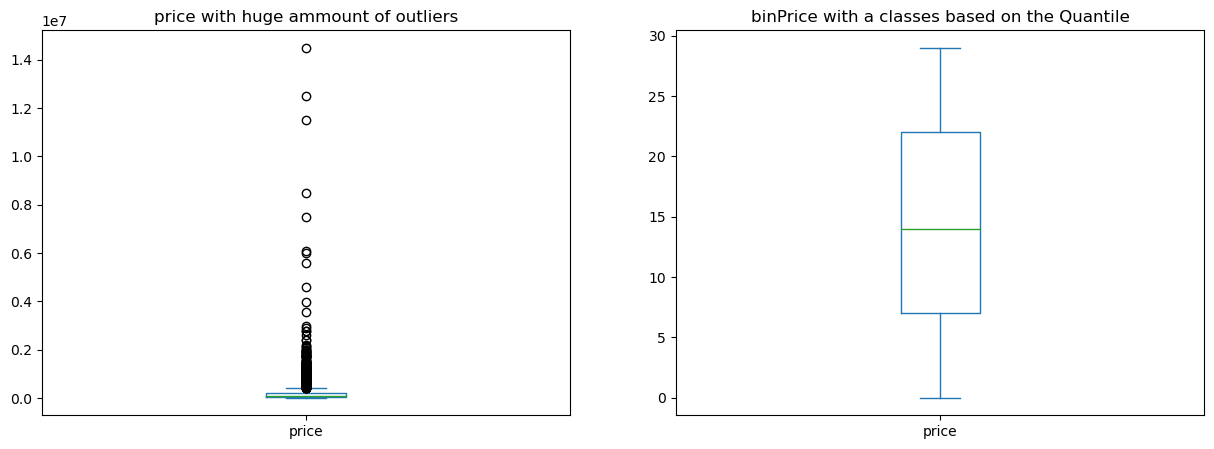

In [64]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
dataset.price.plot(kind="box")
plt.title("price with huge ammount of outliers")
plt.subplot(1,2,2)
pd.qcut(dataset.price,q=30,labels=False).plot(kind="box")
plt.title("binPrice with a classes based on the Quantile");#would help us get around the actual values


In [65]:
dataset=dataset[['Emara_abu dhabi', 'Emara_ajman', 'Emara_alein', 'Emara_alshareqa',
       'Emara_dubai', 'Emara_other', 'Brand_Economy', 'Brand_Luxury',
       'Brand_Mid', 'Brand_Premium', 'Standard_American', 'Standard_Canadian',
       'Standard_Chinese', 'Standard_European', 'Standard_Gulf',
       'Standard_Japanese', 'Standard_Korean', 'year', 'km', 'manual',
       'steering_side', 'car_age', 'kmPerYear', 'km_bins', 'price']]

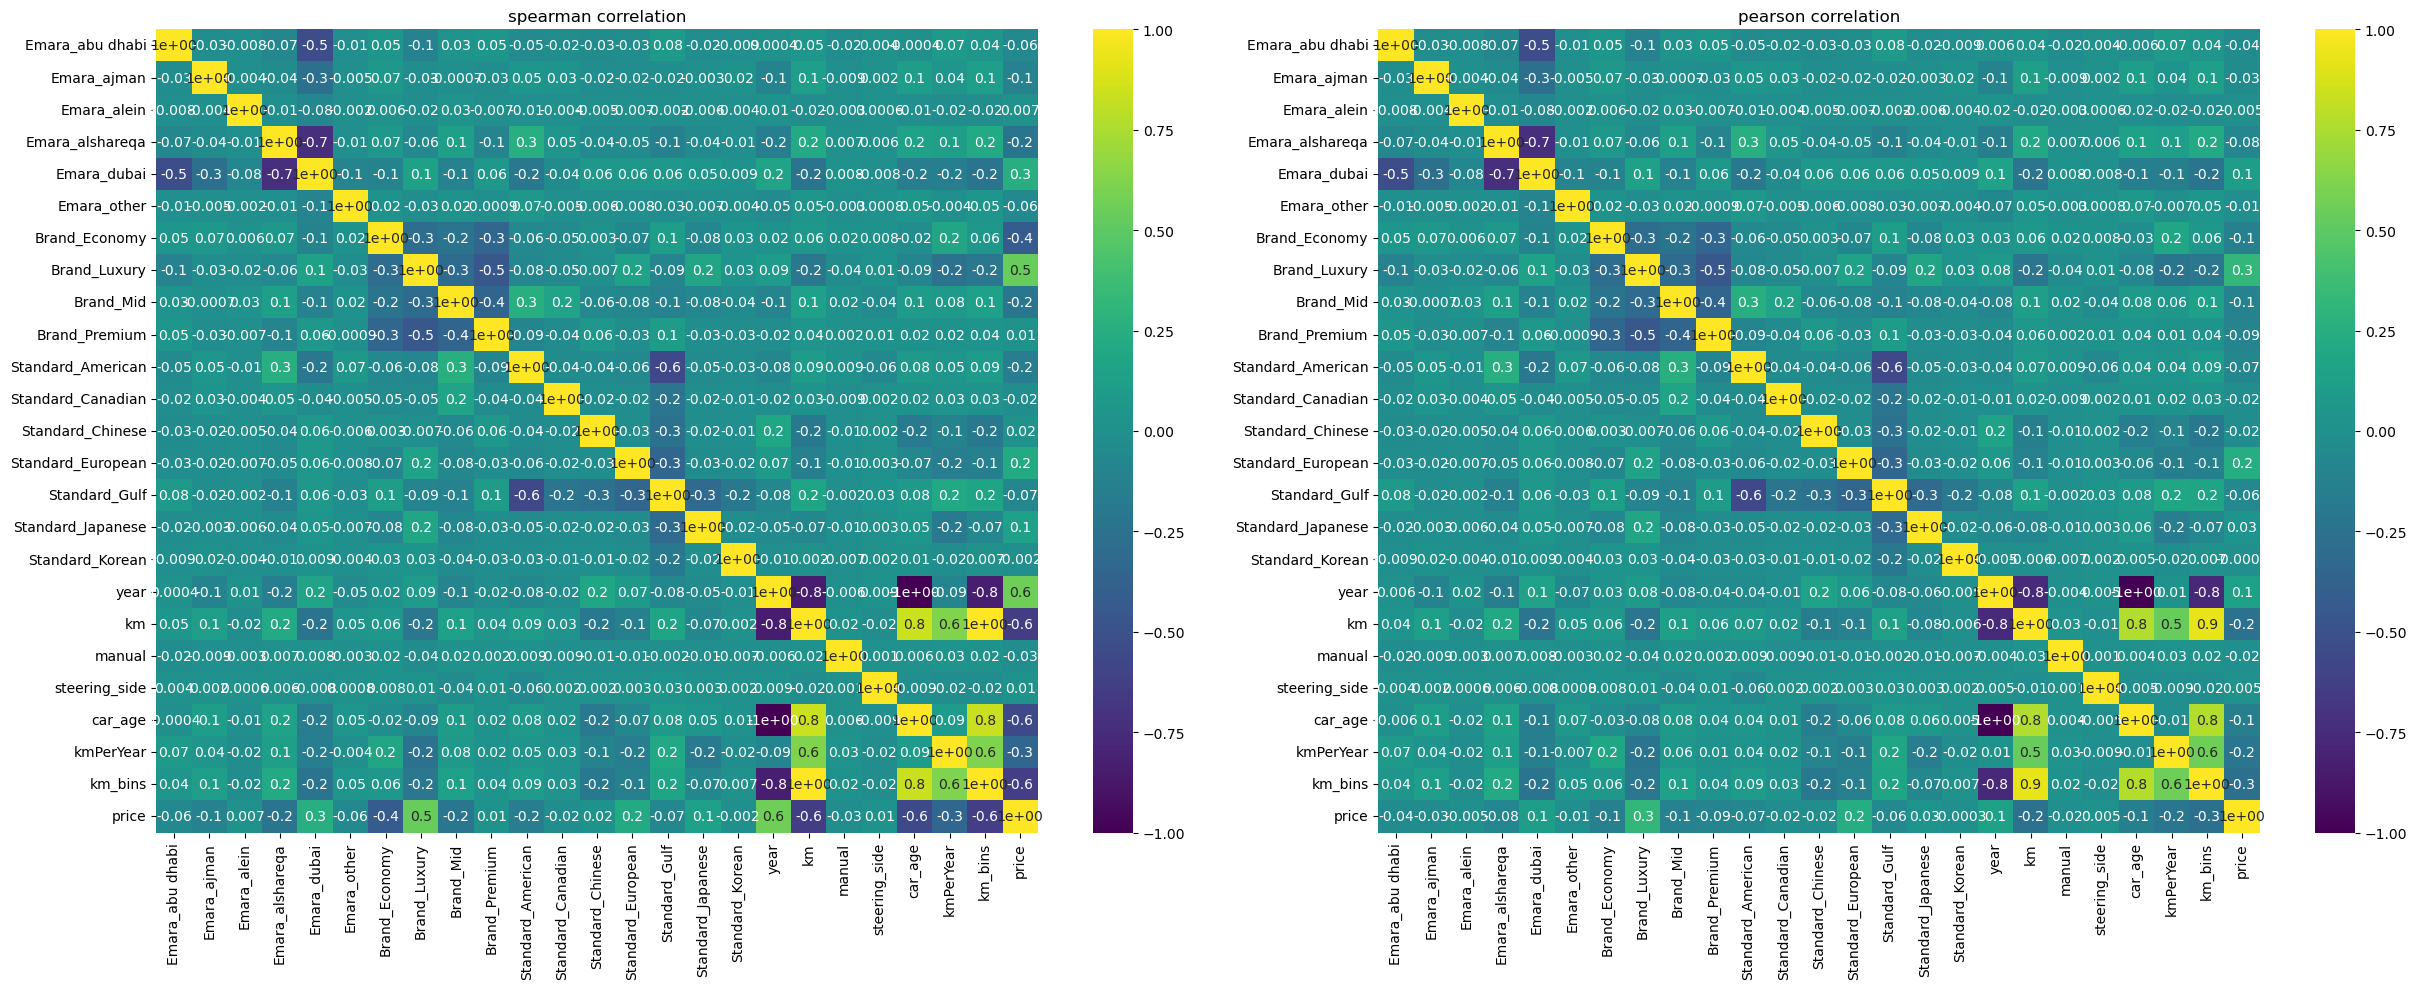

In [66]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
# using spearman helped discovering relationships between the price and the features
# the defult correlation is pearson but it depends on the feature range of values! ⚆_⚆
sns.heatmap(dataset.corr(method="spearman"),cmap="viridis",annot=True,fmt="1.1")
plt.title("spearman correlation");

plt.subplot(1,2,2)
sns.heatmap(dataset.corr(method="pearson"),cmap="viridis",annot=True,fmt="1.1")
plt.title("pearson correlation");
plt.tight_layout()
# plt.pl

In [75]:
corrDataSet=dataset.drop(["km","Standard_Korean","car_age","Emara_alshareqa","Emara_other","km_bins"],axis=1)

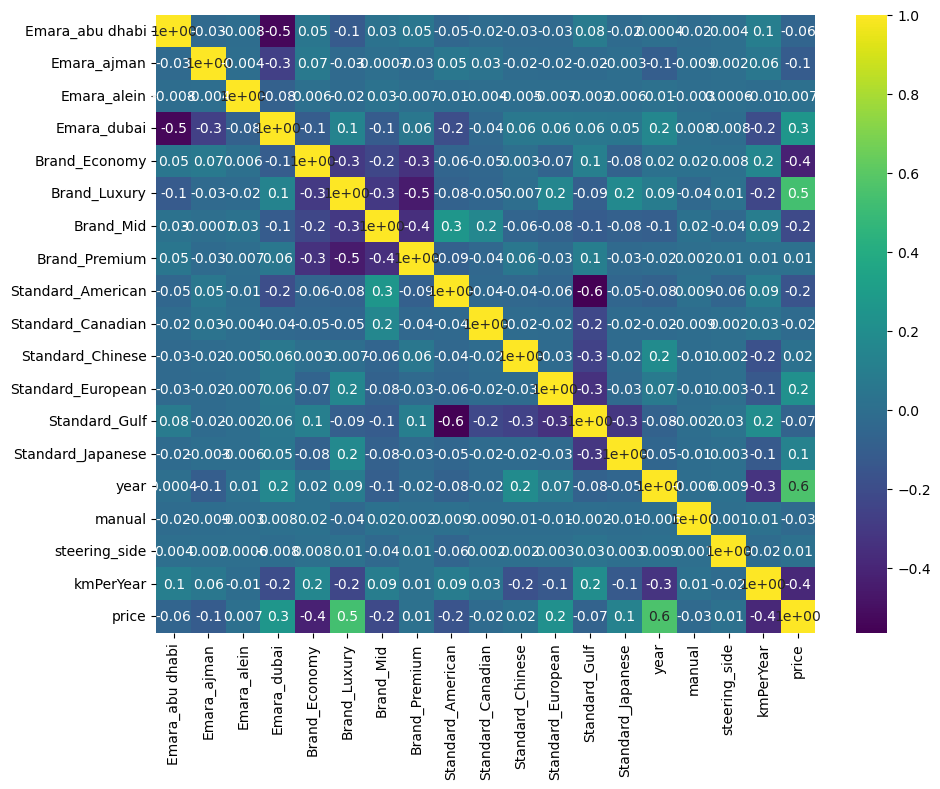

In [80]:
plt.figure(figsize=(10,8))
# corrDataSet.corr().style.background_gradient(cmap="viridis")
sns.heatmap(corrDataSet.corr(method="spearman"),cmap="viridis",annot=True,fmt="1.1")
plt.tight_layout()

In [ ]:
pd.DataFrame(corrDataSet.isnull().sum()[corrDataSet.isnull().sum()>0]).style.background_gradient(cmap="viridis")

,0
kmPerYear,232


> I forgot that there are new cars with age 0 years

In [71]:
dataset["kmPerYear"]=[km/age if age !=0 else km for km,age in zip(dataset["km"],dataset["car_age"])]
corrDataSet["kmPerYear"]=[km/age if age !=0 else km for km,age in zip(dataset["km"],dataset["car_age"])]
pd.DataFrame(corrDataSet.isnull().sum()[corrDataSet.isnull().sum()>0]).style.background_gradient(cmap="viridis")

,0


## **experiment 4**
- trying new features with no coreniality
- restricting the instances to 599

### **Part1**
- on the data used in exp3

In [81]:
EXP4_p1=corrDataSet[corrDataSet.price<264900]
EXP4_p1.head()

,Emara_abu dhabi,Emara_ajman,Emara_alein,Emara_dubai,Brand_Economy,Brand_Luxury,Brand_Mid,Brand_Premium,Standard_American,Standard_Canadian,Standard_Chinese,Standard_European,Standard_Gulf,Standard_Japanese,year,manual,steering_side,kmPerYear,price
0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,2025,0,1,15.000000,69000
1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,2025,0,1,0.000000,62000
2,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015,0,1,16000.000000,34000
3,0,0,0,0,0,0,1,0,0,0,0,0,1,0,2021,0,1,29750.000000,22000
4,0,0,0,0,0,1,0,0,0,0,0,0,1,0,2018,0,1,26142.857143,85000


In [85]:
exp4_KPY=StandardScaler()
exp4_year=StandardScaler()

target='price'
features =EXP4_p1.drop(["price"],axis=1)
Y=EXP4_p1[target]
X=features
x_train,x_validate,y_train,y_validate=train_test_split(X,Y,test_size=0.2,random_state=123)
x_train[["kmPerYear"]]=exp4_KPY.fit_transform(x_train[["kmPerYear"]])
# x_train[["km"]]=exp4_KPY.fit_transform(x_train[["km"]])
x_train[["year"]]=exp4_year.fit_transform(x_train[["year"]])
x_validate[["kmPerYear"]]=exp4_KPY.transform(x_validate[["kmPerYear"]])
# x_validate[["km"]]=exp4_KPY.transform(x_validate[["km"]])
x_validate[["year"]]=exp4_year.transform(x_validate[["year"]])

In [ ]:
exp4_CroosVal=croos_val_Models(X,Y,MODELS,normalize=True,columns_to_scale=["kmPerYear","year"]) # for each fold it applies the stadrization and then it fit the model

In [87]:
exp4_split_val=pd.DataFrame(columns=EvalMetrics)
for Name,Mo in MODELS.items():
    m=Mo()
    m.fit(x_train,y_train)
    Predict1=m.predict(x_validate)
    exp4_split_val.loc[Name]=REG_EvalMetrics(y_validate,Predict1)

In [33]:
exp4_CroosVal.sort_values(by="Mean_Abs_Error")

,R2,Mean_Abs_Error,Mean_squared_error,rmse,median_abs_err,mean_abs_percentage_err,explained_var,max_error
GradientBoosting,0.567064,29358.426037,1.644415e+09,40478.603693,20504.928357,0.448793,0.579508,-174696.506310
HistGradientBoosting,0.556631,29664.348529,1.680691e+09,40911.501055,21069.418166,0.445942,0.569564,-159544.761925
RandomForest,0.530431,30515.832991,1.786693e+09,42069.020271,21875.892159,0.451623,0.542710,-170673.653875
Bagging,0.507795,31134.291613,1.885577e+09,42844.764187,21644.337564,0.461447,0.523519,-172749.040000
Ridge,0.538866,31977.222903,1.752957e+09,41768.128796,25927.410031,0.542933,0.551414,-149533.592477
Lesso,0.538051,31998.831382,1.756216e+09,41806.329128,25916.134406,0.543610,0.550654,-149848.377927
Linear_Regression,0.538045,31999.619365,1.756269e+09,41806.708826,25915.009411,0.543647,0.550641,-149873.752544
ExtraTrees,0.462075,32272.508500,2.045049e+09,45149.582691,22209.679167,0.471781,0.472449,-186885.700000
AdaBoost,0.490406,34629.760729,1.951637e+09,44192.790951,28251.120808,0.638544,0.515848,-142909.295183
DecisionTree,0.321188,36186.439273,2.566736e+09,50259.648969,25342.046154,0.523908,0.335917,-207619.800000


In [34]:
exp4_split_val.sort_values(by="Mean_Abs_Error")

,R2,mean_error,Mean_Abs_Error,Root_Mean_Squared_Error,Mean_Percentage_error,Mean_Abs_Percentage_error
HistGradientBoosting,0.566774,-1007.416851,28476.675784,39725.747038,-22.773881,0.439880
GradientBoosting,0.583284,-1400.766146,28507.887877,38961.404309,-24.984826,0.448738
RandomForest,0.536125,-1757.480656,29259.705489,41106.941860,-24.514870,0.456452
Bagging,0.512652,-1020.040946,30227.552369,42134.150011,-23.148620,0.464792
ExtraTrees,0.484100,-881.070285,30486.845172,43350.822823,-21.948680,0.457713
Ridge,0.531172,-2426.865887,32280.536412,41325.845292,-25.593222,0.558555
Linear_Regression,0.530746,-2410.244720,32289.516532,41344.610078,-25.515486,0.558757
Lesso,0.530724,-2409.509166,32289.871553,41345.578975,-25.519705,0.558756
AdaBoost,0.486390,-9895.667543,33252.473805,43254.526112,-46.138203,0.607676
ExtraTree,0.306705,-2117.208592,35800.688039,50254.383216,-25.907842,0.559159


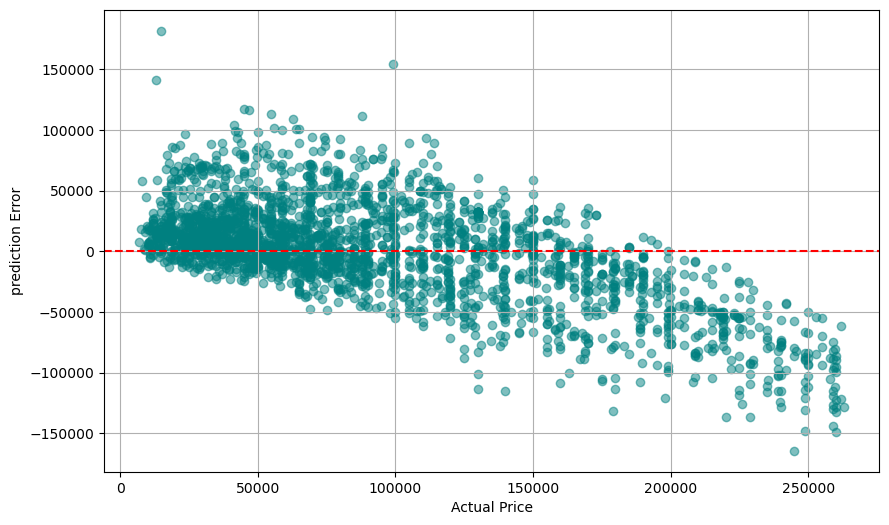

In [89]:

pipeline = Pipeline([
    ('pre', ColumnTransformer(
    transformers=[('scale', StandardScaler(), ["kmPerYear"])],
    remainder='passthrough')),
    ('model',MODELS["GradientBoosting"]())
])

exp1_4_Y_Pred=cross_val_predict(pipeline,X,Y,cv=20)
y_pred=exp1_4_Y_Pred
y_true=Y
error=y_pred-y_true
plt.figure(figsize=(10,6))
plt.scatter(y_true,error,alpha=0.5,color='teal')
plt.axhline(0,color="red",linestyle="--")

plt.xlabel("Actual Price")
plt.ylabel("prediction Error")
plt.grid(True)

In [90]:
REG_EvalMetrics(y_true,y_pred)

{'R2': 0.5884767989910906,
 'mean_error': -132.6131716908397,
 'Mean_Abs_Error': 29317.391355460244,
 'Root_Mean_Squared_Error': 40048.14999143175,
 'Mean_Percentage_error': -23.745440480769084,
 'Mean_Abs_Percentage_error': 0.45062272186628}

### **part2**
- restrecting the data to lower prices

In [93]:
EXP4_p2=corrDataSet[corrDataSet.price<40000]
EXP4_p2.head()

,Emara_abu dhabi,Emara_ajman,Emara_alein,Emara_dubai,Brand_Economy,Brand_Luxury,Brand_Mid,Brand_Premium,Standard_American,Standard_Canadian,Standard_Chinese,Standard_European,Standard_Gulf,Standard_Japanese,year,manual,steering_side,kmPerYear,price
2,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2015,0,1,16000.000000,34000
3,0,0,0,0,0,0,1,0,0,0,0,0,1,0,2021,0,1,29750.000000,22000
10,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2017,0,1,27333.625000,29000
46,0,0,0,0,0,0,0,1,1,0,0,0,0,0,2016,0,1,36666.666667,17500
48,0,0,0,0,1,0,0,0,0,0,0,0,1,0,2020,0,1,25000.000000,25500


In [94]:
exp4_KPY=StandardScaler()
exp4p2_year=StandardScaler()

target='price'
features =EXP4_p2.drop(["price"],axis=1)
Y=EXP4_p2[target]
X=features
x_train,x_validate,y_train,y_validate=train_test_split(X,Y,test_size=0.2,random_state=123)

x_train[["kmPerYear"]]=exp4_KPY.fit_transform(x_train[["kmPerYear"]])
x_validate[["kmPerYear"]]=exp4_KPY.transform(x_validate[["kmPerYear"]])
x_train[["year"]]=exp4p2_year.fit_transform(x_train[["year"]])
x_validate[["year"]]=exp4p2_year.transform(x_validate[["year"]])

In [96]:
exp4p2_CroosVal=croos_val_Models(X,Y,MODELS,normalize=True,columns_to_scale=["kmPerYear","year"])

In [97]:
Class_exp4p2=pd.DataFrame(columns=EvalMetrics)
for Name,Mo in MODELS.items():
    m=Mo()
    m.fit(x_train,y_train)
    Predict1=m.predict(x_validate)
    Class_exp4p2.loc[Name]=REG_EvalMetrics(y_validate,Predict1)

In [98]:
Class_exp4p2.sort_values(by="Mean_Abs_Error")

,R2,mean_error,Mean_Abs_Error,Root_Mean_Squared_Error,Mean_Percentage_error,Mean_Abs_Percentage_error
RandomForest,2.307248e-01,2.115342e+01,6.329536e+03,7.940656e+03,-11.825476,0.303436
GradientBoosting,2.519244e-01,-4.681059e+01,6.335699e+03,7.830478e+03,-12.027956,0.303708
Huber,2.395138e-01,-2.571580e+02,6.397808e+03,7.895165e+03,-12.462904,0.300330
Bagging,1.690993e-01,2.823336e+02,6.414939e+03,8.252587e+03,-11.107058,0.309591
Linear_Regression,2.379665e-01,-1.753417e+02,6.454792e+03,7.903193e+03,-12.559731,0.304370
Lesso,2.365852e-01,-2.054374e+02,6.480886e+03,7.910352e+03,-12.850484,0.306620
Ridge,2.321725e-01,-1.902257e+02,6.490500e+03,7.933181e+03,-12.887352,0.307495
ExtraTrees,1.734478e-01,1.082959e+02,6.516927e+03,8.230964e+03,-10.341755,0.307552
AdaBoost,2.411569e-01,-1.102985e+02,6.626225e+03,7.886631e+03,-13.940931,0.320619
HistGradientBoosting,1.740040e-01,2.156706e+02,6.690399e+03,8.228194e+03,-11.553853,0.319661


In [99]:
exp4p2_CroosVal.sort_values(by="Mean_Abs_Error")

,R2,Mean_Abs_Error,Mean_squared_error,rmse,median_abs_err,mean_abs_percentage_err,explained_var,max_error
Ridge,0.168962,6.249841e+03,5.650633e+07,7.493132e+03,5819.058235,0.286383,0.194467,-2.108015e+04
Huber,0.146513,6.252602e+03,5.776962e+07,7.561498e+03,5684.996659,0.284912,0.177418,-2.230791e+04
Lesso,0.163141,6.254611e+03,5.698285e+07,7.526057e+03,5774.570994,0.286146,0.188874,-2.191441e+04
Linear_Regression,0.162628,6.254649e+03,5.702940e+07,7.529233e+03,5775.530672,0.286148,0.188402,-2.200556e+04
GradientBoosting,0.140022,6.261237e+03,5.843132e+07,7.629648e+03,5577.573567,0.288067,0.157528,-2.084592e+04
RandomForest,0.107632,6.301981e+03,6.034481e+07,7.789151e+03,5387.815667,0.288011,0.115945,-1.974845e+04
AdaBoost,0.185475,6.305374e+03,5.580694e+07,7.541142e+03,6055.655916,0.293323,0.187903,-1.791965e+04
HistGradientBoosting,0.076758,6.472604e+03,6.298895e+07,7.916602e+03,5665.210645,0.294041,0.099002,-2.125529e+04
ElasticNet,0.134647,6.509017e+03,5.993294e+07,7.731582e+03,6471.916086,0.310473,0.155061,-1.668399e+04
Bagging,0.055568,6.594909e+03,6.414662e+07,7.960369e+03,5860.980000,0.289540,0.073700,-2.030096e+04


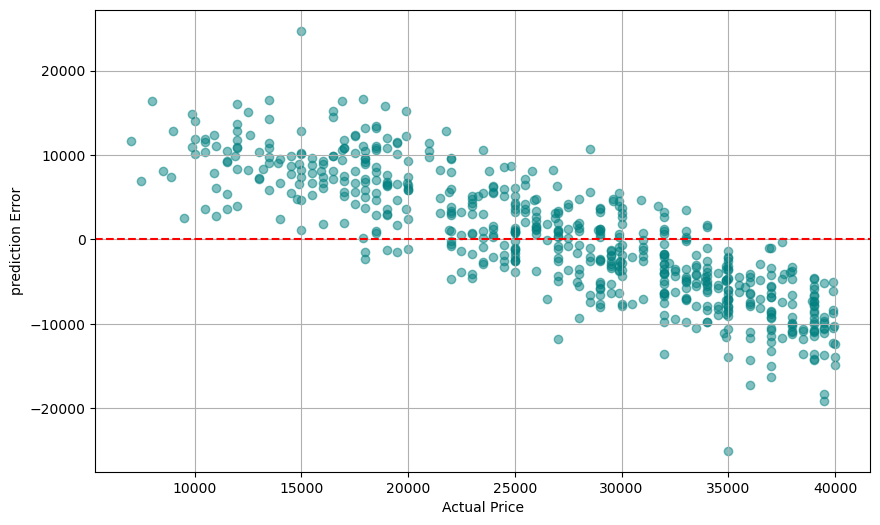

In [102]:
pipeline = Pipeline([
    ('pre', ColumnTransformer(
    transformers=[('scale', StandardScaler(), ["kmPerYear"])],
    remainder='passthrough')),
    ('model',MODELS["Ridge"]())
])

exp1_3_Y_Pred=cross_val_predict(pipeline,X,Y,cv=20)
y_pred=exp1_3_Y_Pred
y_true=Y
error=y_pred-y_true
plt.figure(figsize=(10,6))
plt.scatter(y_true,error,alpha=0.5,color='teal')
plt.axhline(0,color="red",linestyle="--")

plt.xlabel("Actual Price")
plt.ylabel("prediction Error")
plt.grid(True)

In [103]:
REG_EvalMetrics(y_true,y_pred)

{'R2': 0.23365412967738097,
 'mean_error': -18.067318278879476,
 'Mean_Abs_Error': 6154.412696692087,
 'Root_Mean_Squared_Error': 7393.928883932742,
 'Mean_Percentage_error': -10.265796564417355,
 'Mean_Abs_Percentage_error': 0.28121980014541914}

---

### **EXP4 results**
eliminated highly correlated features and played with the price range in the data selected

#### ***part1***:
- used data with prices less than 270000
- without the `km` feature but with `kmPerYear`

|metric| GradientBoosting |
|-----|-----|
|R2: |58.8%|
|Mean_Abs_Error | 29317 AED|
|Mean_Abs_Percentage_error |45%|

#### ***part2***:
- reduced the size of the data to 599 records with prices no more than 40000

|metric| Ridge |
|-----|-----|
|R2: |23%|
|Mean_Abs_Error | 6154 AED|
|Mean_Abs_Percentage_error |28.1%|

## <div style="color:lightgreen;background-color:black;padding:10px">***PCA***
### **experiment 5**
- was applied on 600 records that are less than 40000 as in EXP4 part2
- applied with normalization 

### Getting the data


In [6]:
dataset=pd.read_csv("DataSetNoOutLier.csv",index_col="Unnamed: 0")
dataset=dataset.sort_values(by="price")[:600]
current_year=datetime.now().year
dataset.head()


,Emara_abu dhabi,Emara_ajman,Emara_alein,Emara_alshareqa,Emara_dubai,Emara_other,Brand_Economy,Brand_Luxury,Brand_Mid,Brand_Premium,...,Standard_Chinese,Standard_European,Standard_Gulf,Standard_Japanese,Standard_Korean,year,km,manual,steering_side,price
2111,0,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,2011,200000,0,1,7000
1685,0,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,2006,283000,0,1,7500
2869,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,2015,115000,0,1,8000
2761,0,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,2010,380000,0,1,8500
1933,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,2010,187000,0,1,8900


In [7]:
dataset.corr().style.background_gradient("YlGn_r")

,Emara_abu dhabi,Emara_ajman,Emara_alein,Emara_alshareqa,Emara_dubai,Emara_other,Brand_Economy,Brand_Luxury,Brand_Mid,Brand_Premium,Standard_American,Standard_Canadian,Standard_Chinese,Standard_European,Standard_Gulf,Standard_Japanese,Standard_Korean,year,km,manual,steering_side,price
Emara_abu dhabi,1.000000,-0.055898,nan,-0.123024,-0.379883,-0.023160,0.043487,-0.046915,-0.037759,0.008135,-0.065482,0.026558,nan,0.151782,-0.018831,0.037906,0.045141,0.035851,-0.010998,-0.023160,nan,0.021405
Emara_ajman,-0.055898,1.000000,nan,-0.107736,-0.332674,-0.020282,0.083119,-0.041085,-0.041073,-0.032455,0.100848,-0.027303,nan,-0.018125,-0.070675,-0.024038,0.057179,-0.049727,0.067058,-0.020282,nan,-0.100256
Emara_alein,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Emara_alshareqa,-0.123024,-0.107736,nan,1.000000,-0.732177,-0.044638,0.020344,0.074697,0.116805,-0.160056,0.416093,0.009580,nan,-0.039892,-0.304874,-0.052905,-0.048940,0.082080,0.001995,0.001941,nan,0.071262
Emara_dubai,-0.379883,-0.332674,nan,-0.732177,1.000000,-0.137837,-0.070801,-0.017451,-0.067241,0.144114,-0.384550,-0.007137,nan,-0.034349,0.313589,0.038597,-0.005812,-0.048421,-0.037635,0.021206,nan,-0.009715
Emara_other,-0.023160,-0.020282,nan,-0.044638,-0.137837,1.000000,-0.035424,-0.017023,0.029258,0.016071,0.086026,-0.011312,nan,-0.007510,-0.057394,-0.009960,-0.009213,-0.088066,0.055406,-0.008403,nan,-0.082577
Brand_Economy,0.043487,0.083119,nan,0.020344,-0.070801,-0.035424,1.000000,-0.147961,-0.472298,-0.544503,-0.112688,-0.098327,nan,0.060793,0.126935,-0.086570,0.023027,0.296205,-0.200624,-0.035424,nan,-0.111283
Brand_Luxury,-0.046915,-0.041085,nan,0.074697,-0.017451,-0.017023,-0.147961,1.000000,-0.110071,-0.126898,0.024895,-0.022915,nan,-0.015213,-0.116264,0.325689,0.074652,-0.244205,-0.000410,-0.017023,nan,-0.017522
Brand_Mid,-0.037759,-0.041073,nan,0.116805,-0.067241,0.029258,-0.472298,-0.110071,1.000000,-0.405066,0.257956,0.208188,nan,-0.048560,-0.254890,-0.064401,-0.021385,0.042111,0.011652,0.071056,nan,0.016376
Brand_Premium,0.008135,-0.032455,nan,-0.160056,0.144114,0.016071,-0.544503,-0.126898,-0.405066,1.000000,-0.134591,-0.084330,nan,-0.012017,0.152006,0.025711,-0.032722,-0.255452,0.199088,-0.023287,nan,0.107761


In [8]:
dataset.drop(["Emara_alein","Standard_Chinese","steering_side"],axis=1,inplace=True) # they have only one value in each without any variance 

### **splitting** + **normalizing**

In [37]:
target='price'
features =[i for i in dataset.columns if i != target]
y=dataset[target]
x=dataset[features]
x_train,x_validate,y_train,y_validate=train_test_split(x,y,test_size=0.2,random_state=123)

# standardizing the features *~(￣▽￣)~*
x_transformer=StandardScaler()
x_train[["km","year",]]=x_transformer.fit_transform(x_train[["km","year",]])
x_validate[["km","year",]]=x_transformer.transform(x_validate[["km","year",]])

### **fitting** **pca**

In [38]:
pca=PCA()
pca.fit(x_train)
pcaData=pca.transform(x_train)
pcaData.shape

(480, 18)

### ***pca summery*** and **selecting** the **optimal number of components.**

In [39]:
pcaSummary = pd.DataFrame({'Standard deviation': np.sqrt(pca.explained_variance_),
 'Proportion of variance': pca.explained_variance_ratio_,
 'Cumulative proportion': np.cumsum(pca.explained_variance_ratio_)})
DpcsSummary = pcaSummary.transpose()
DpcsSummary.columns = ["PC"+str(i) for i in range(1,pcaData.shape[1]+1)]
DpcsSummary.round(4)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
Standard deviation,1.2646,0.6993,0.6400,0.5633,0.4972,0.3656,0.2899,0.2236,0.1834,0.1741,0.1114,0.0957,0.0903,0.0891,0.0860,0.0500,0.0,0.0
Proportion of variance,0.4647,0.1421,0.1190,0.0922,0.0718,0.0388,0.0244,0.0145,0.0098,0.0088,0.0036,0.0027,0.0024,0.0023,0.0022,0.0007,0.0,0.0
Cumulative proportion,0.4647,0.6067,0.7257,0.8180,0.8898,0.9286,0.9531,0.9676,0.9774,0.9862,0.9898,0.9924,0.9948,0.9971,0.9993,1.0000,1.0,1.0


The varience of the first 10 PCAs: 96.76%


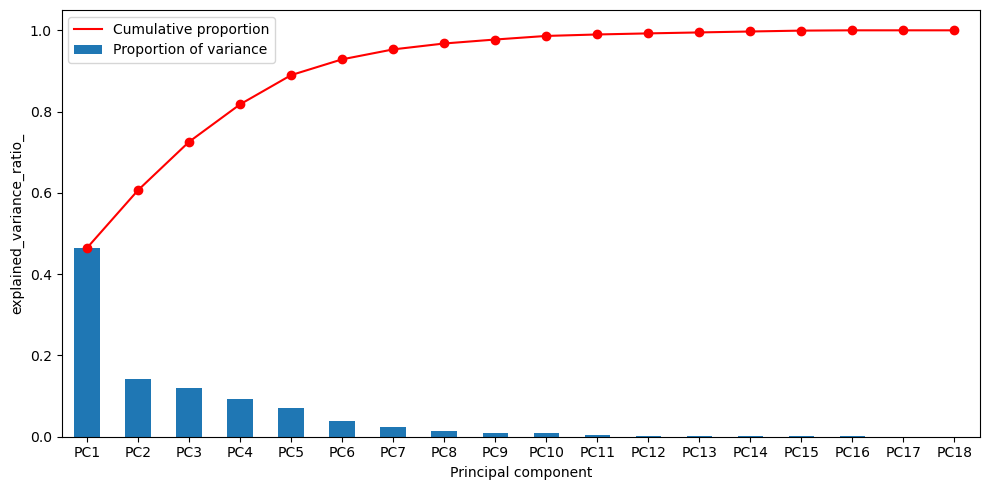

In [40]:
plt.figure(figsize=(10,5))
DpcsSummary.loc['Proportion of variance'].plot(kind='bar')
DpcsSummary.loc['Cumulative proportion'].plot(c='r');
plt.plot(DpcsSummary.loc['Cumulative proportion'],'ro')
plt.xlabel("Principal component")
plt.ylabel("explained_variance_ratio_")
plt.legend()
plt.tight_layout()
#--------------------------------------------------------------------
print("The varience of the first 10 PCAs: ",round(np.sum(DpcsSummary.loc['Cumulative proportion',["PC8"]])*100,2),"%",sep="")

In [41]:
# ¯\_(ツ)_/¯ restricting the data to the first 9 pca columns ===================
pcaData=pd.DataFrame(pcaData,columns=DpcsSummary.columns)[[f"PC{i}" for i in range(1,9)]]
pcaData.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-1.239302,-0.515294,1.927410,-0.236489,0.000894,-0.185925,-0.088581,-0.135141
1,0.241431,-0.402210,-0.254319,0.747301,-0.334741,0.086528,-0.105392,-0.007119
2,-2.266185,0.601646,0.244992,0.466329,0.580867,-0.474175,-0.249478,-0.035777
3,-0.220158,-0.358867,0.223004,-0.514505,-0.741151,-0.323252,0.042406,0.021300
4,0.213448,-0.559777,0.359281,-0.381330,-0.781016,-0.325520,0.029333,0.020554


In [42]:
pcaData.corr().style.background_gradient("Reds")

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
PC1,1.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000
PC2,0.000000,1.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000
PC3,-0.000000,-0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
PC4,-0.000000,-0.000000,0.000000,1.000000,0.000000,0.000000,-0.000000,0.000000
PC5,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-0.000000,-0.000000
PC6,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-0.000000
PC7,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,1.000000,-0.000000
PC8,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,1.000000


### ***training the models***

In [43]:
pca_split_eval=pd.DataFrame(columns=EvalMetrics)
pca_x_test=pd.DataFrame(pca.transform(x_validate),columns=DpcsSummary.columns)[[f"PC{i}" for i in range(1,9)]]

In [44]:
for Name,Mo in MODELS.items():
    m=Mo()
    m.fit(pcaData,y_train)
    Predict1=m.predict(pca_x_test)
    pca_split_eval.loc[Name]=REG_EvalMetrics(y_validate,Predict1)

In [45]:
pca_split_eval.sort_values(by="Mean_Abs_Error")

,R2,mean_error,Mean_Abs_Error,Root_Mean_Squared_Error,Mean_Percentage_error,Mean_Abs_Percentage_error
Lesso,0.248281,787.364476,5998.286284,7.250727e+03,-7.002308,0.269689
Linear_Regression,0.248184,788.340803,5998.462874,7.251195e+03,-6.996292,0.269685
Ridge,0.248217,787.045867,5999.638017,7.251034e+03,-7.017557,0.269772
Huber,0.234340,692.690052,6025.584295,7.317653e+03,-6.990032,0.270171
AdaBoost,0.178677,793.585171,6292.693074,7.578979e+03,-7.853299,0.285568
ElasticNet,0.187013,658.558905,6351.525998,7.540421e+03,-9.250920,0.293250
Bagging,0.044976,569.871319,6371.822569,8.172610e+03,-7.167235,0.284103
RandomForest,0.074523,588.109137,6434.490050,8.045192e+03,-7.572572,0.288707
ExtraTrees,0.002739,565.730958,6500.676958,8.351376e+03,-7.472816,0.289641
GradientBoosting,0.042103,889.539403,6568.224694,8.184893e+03,-6.487119,0.291605


### ***the best model results***

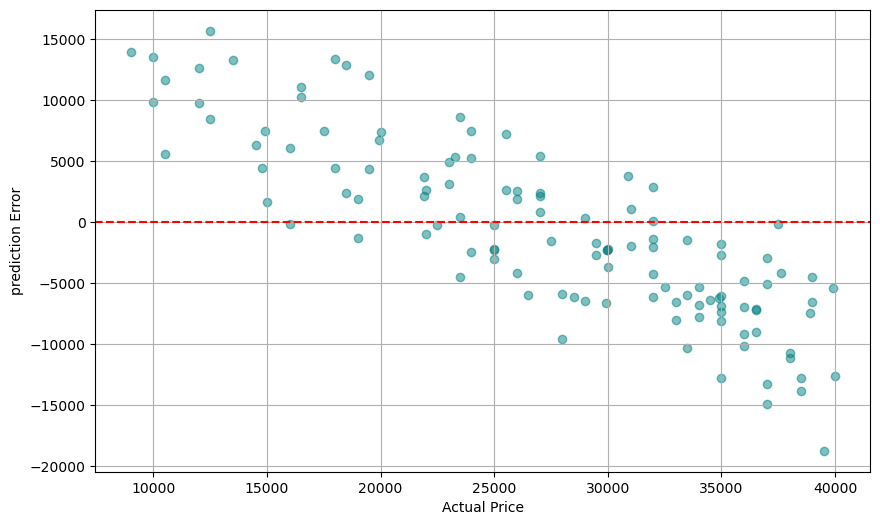

In [46]:
m=MODELS["Linear_Regression"]()
m.fit(pcaData,y_train)
Predict_PCA=m.predict(pca_x_test)

y_pred=Predict_PCA
y_true=y_validate

error=y_pred-y_true
plt.figure(figsize=(10,6))
plt.scatter(y_true,error,alpha=0.5,color='teal')
plt.axhline(0,color="red",linestyle="--")

plt.xlabel("Actual Price")
plt.ylabel("prediction Error")
plt.grid(True)

In [48]:
REG_EvalMetrics(y_validate,y_pred)

{'R2': 0.24818360072311507,
 'mean_error': 788.3408033726184,
 'Mean_Abs_Error': 5998.462873934469,
 'Root_Mean_Squared_Error': 7251.195117347646,
 'Mean_Percentage_error': -6.996291735326423,
 'Mean_Abs_Percentage_error': 0.2696851987065516}

# ***Results summary***

> ### **EXP1 results**
>-------These results could defer from run to run and it is based on a single observation
>
> - ***part1***
>    - *CrossValidation:*
>       - the best MAE with cross validation was ***133513*** with ***random forest*** algorithm 
>       - the best R² was **0.19664** with ***Lesso*** regression
>    - SplitPredict validation:
>       - the best MAE with cross validation was ***128373.295*** with ***random forest*** algorithm 
>       - the best R² was **0.40223** with ***Extra Trees*** regression
> 
> - ***part2*** 
>    - *CrossValidation:*
>       - the best MAE with cross validation was ***128293*** with ***random forest*** algorithm 
>       - the best R² was **0.196678** with ***Ridge*** regression
>    - SplitPredict validation:
>       - the best MAE with cross validation was ***131990*** with ***ExtraTrees*** algorithm 
>       - the best R² was **0.41352** with ***Extra Trees*** regression
>
> |metric|EXP1_Part1_*RandomForest*|EXP1_Part2_*Huber*|
> |-----|-----|-----|
> |R2: |11.7%|7.9%|
> |Mean_Abs_Error | 131166 AED|129328 AED
> |Mean_Abs_Percentage_error |62.4%|71.9%|
> #### ***General findings:***
>
> the results are slightly improved by the normalization,but still bad 
> - MAE :
>       - part1 ranged between [131000 to much bigger numbers]
>       - part2 ranged between [128000 to much bigger numbers]->_*improved distance based algorithms' performance*_
>
> - R²:
>       - stayed the same for both sub-experiments in experiment1
>       - in all of the runs the R² is less than 13% and more than 5% 
>
> - about cross-validation:
>       - it gave me a much worse results than using the split-based validation
>       - the split-based validation is much optimistic 
>
> ### Justifications for missing predicting the price by more than 125k AED:
> `Notice that the problem is with the Price huge outliers values`
> - there some variebility in the price could be explained using features that are not represented in the data e.g.`color`
> 
> 
> ---
> 
> 
> 
> ### **EXP2**
> 
> > trying solution #1 for left skewed hard to predict prices
> 
> - in this experiment I tried to make the model predict the `log of the priced`
> 
> - and toke the exponential of the result and compared it with the actual price 
> 
> 
> 
> - the mean abs error improved from 128000 AED to 109000 AED
> 
> - and the MAPE dropped to 47%
> 
> 
> 
>|metric|SVR|
>|-----|-----|
>|R2: |21%|
> |Mean_Abs_Error | 109660 AED|
> |Mean_Abs_Percentage_error |47.1%|
> ---
> 
> 
> ### **EXP3**
> - restricting the data to have the cars that has less price than 265k helped reducing the MAE
> - but the reduction wasn't good enough to take 
>
> |metric|**Gradient_Boosting**|
> |-----|-----|
> |R2: |60%|
> |Mean_Abs_Error | 28754 AED|
> |Mean_Abs_Percentage_error |43.6%|
> 
> 
> ---
> 
> 
> 
> ### **EXP4**
> 
> `==== all these results are using cross validation ====`
> 
> - #### Part1 :same as EXP3 but with features selected via correlations
> - #### Part2: same as part1 but with much reduced data with prices <40k AED
> 
> 
> |metric|Prt1_**GradientBoosting**|Part2**Ridge**|
> |-----|-----|-----|
> |R2: |58.8%|23.3%|
> |Mean_Abs_Error | 29317 AED|6154 AED|
> |Mean_Abs_Percentage_error |45%|28.1%|
> <div style="color:lightgreen;background-color:#131313;width:fit-content;font-size:15px;padding:5px;"><strong>reducing the data to 600 records improved the MAPE by 17%</strong></div>
>
> ---
>
> ### **EXP5_PCA**
> - reduced dimensionality from 22 to 8 pca columns
> > - with reduced data ,same as EXP4 part2
> 
> > - _`didn't use cross validation in this experiment`_
> 
> 
> 
> |metric|**Linear_Regression**|
> |-----|-----|
> |R2: |24.8%|
> |Mean_Abs_Error | 5998 AED|
> |Mean_Abs_Percentage_error |26.9%|
> 
> <div style="color:lightgreen;background-color:#131313;width:fit-content;padding:5px;font-size:15px"><strong>the results with 8 columns pca improved the percentage error by 1%</strong></div>
>
>
> ---
